In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [2]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):    
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    # Add some number of separable convolution layers
    for _ in range(2):
        output_layer = separable_conv2d_batchnorm( output_layer, filters, strides=1)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    layer1 = encoder_block(inputs , filters=32 , strides=2)
    layer2 = encoder_block(layer1, filters=64 , strides=2)
    layer3 = encoder_block(layer2, filters=128, strides=2)
    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer4 = conv2d_batchnorm(layer3, filters=256, kernel_size=1, strides=1)
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer5 = decoder_block(layer4, layer2, filters=128 )
    layer6 = decoder_block(layer5, layer1, filters=64  )
    layer7 = decoder_block(layer6, inputs , filters=32  )
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer7)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [9]:
learning_rate = 0.001
batch_size = 80
num_epochs = 200
steps_per_epoch = 4370 // batch_size + 1
validation_steps = 1184 // batch_size + 1
workers = 10

Epoch 1/200
54/55 [============================>.] - ETA: 1s - loss: 74.2677

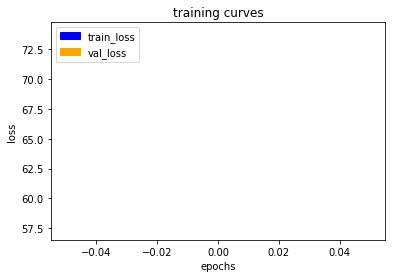

55/55 [==============================] - 74s 1s/step - loss: 73.9098 - val_loss: 57.3617
Epoch 2/200
54/55 [============================>.] - ETA: 1s - loss: 39.2520

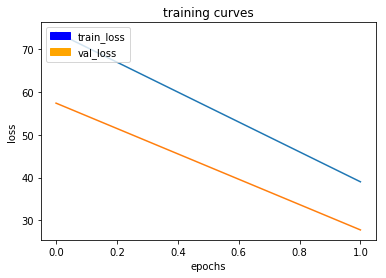

55/55 [==============================] - 61s 1s/step - loss: 39.0065 - val_loss: 27.7746
Epoch 3/200
54/55 [============================>.] - ETA: 1s - loss: 18.4113

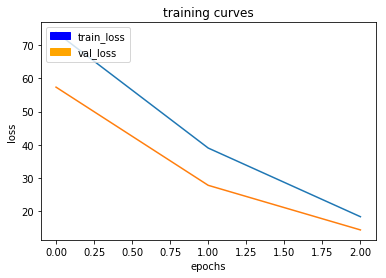

55/55 [==============================] - 61s 1s/step - loss: 18.3162 - val_loss: 14.3348
Epoch 4/200
54/55 [============================>.] - ETA: 1s - loss: 9.9959 

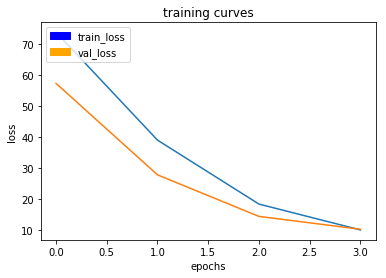

55/55 [==============================] - 60s 1s/step - loss: 9.9595 - val_loss: 10.1755
Epoch 5/200
54/55 [============================>.] - ETA: 1s - loss: 6.7912

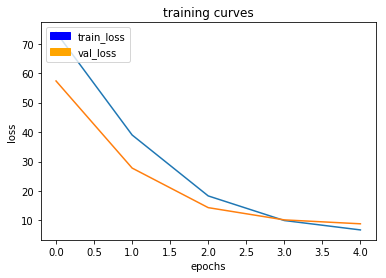

55/55 [==============================] - 61s 1s/step - loss: 6.7697 - val_loss: 8.8473
Epoch 6/200
54/55 [============================>.] - ETA: 1s - loss: 5.2579

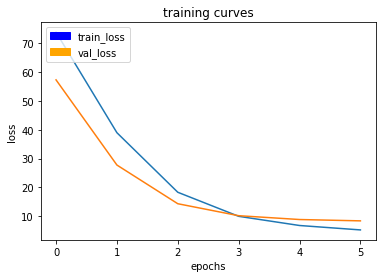

55/55 [==============================] - 61s 1s/step - loss: 5.2359 - val_loss: 8.3827
Epoch 7/200
54/55 [============================>.] - ETA: 1s - loss: 4.4089

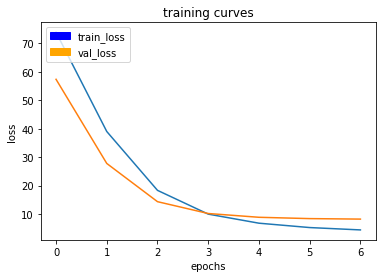

55/55 [==============================] - 61s 1s/step - loss: 4.4064 - val_loss: 8.2082
Epoch 8/200
54/55 [============================>.] - ETA: 1s - loss: 3.8493

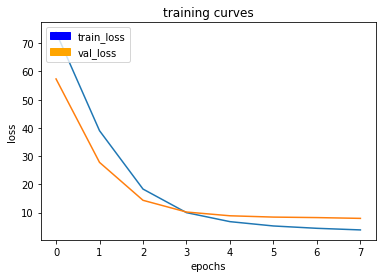

55/55 [==============================] - 60s 1s/step - loss: 3.8369 - val_loss: 7.9292
Epoch 9/200
54/55 [============================>.] - ETA: 1s - loss: 3.4603

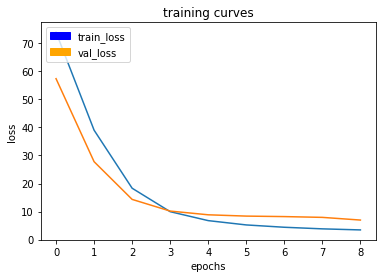

55/55 [==============================] - 60s 1s/step - loss: 3.4590 - val_loss: 6.9723
Epoch 10/200
54/55 [============================>.] - ETA: 1s - loss: 3.1996

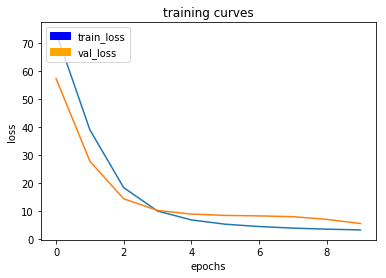

55/55 [==============================] - 61s 1s/step - loss: 3.1909 - val_loss: 5.4824
Epoch 11/200
54/55 [============================>.] - ETA: 1s - loss: 2.9575

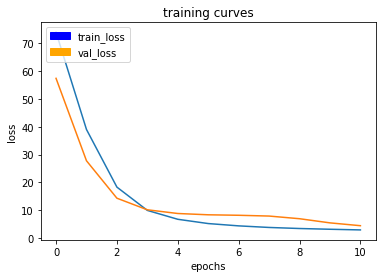

55/55 [==============================] - 61s 1s/step - loss: 2.9540 - val_loss: 4.4687
Epoch 12/200
54/55 [============================>.] - ETA: 1s - loss: 2.7809

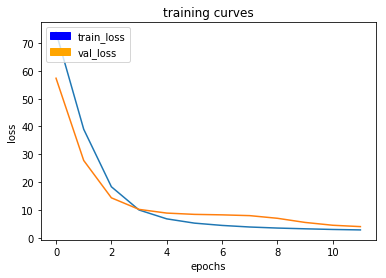

55/55 [==============================] - 61s 1s/step - loss: 2.7901 - val_loss: 3.9779
Epoch 13/200
54/55 [============================>.] - ETA: 1s - loss: 2.7434

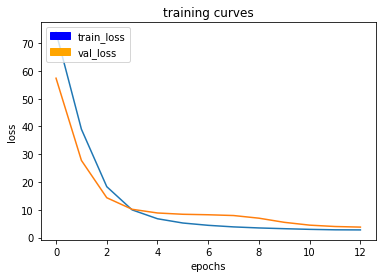

55/55 [==============================] - 61s 1s/step - loss: 2.7514 - val_loss: 3.7606
Epoch 14/200
54/55 [============================>.] - ETA: 1s - loss: 2.5317

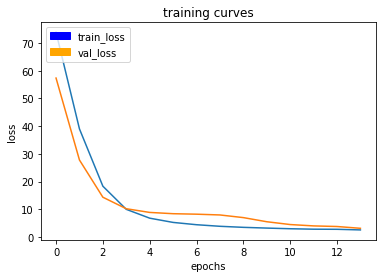

55/55 [==============================] - 61s 1s/step - loss: 2.5284 - val_loss: 3.1095
Epoch 15/200
54/55 [============================>.] - ETA: 1s - loss: 2.4142

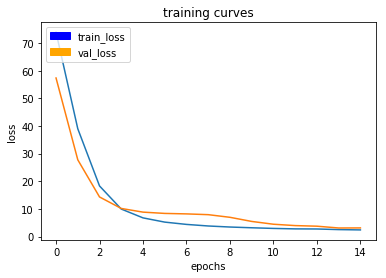

55/55 [==============================] - 60s 1s/step - loss: 2.4138 - val_loss: 3.1340
Epoch 16/200
54/55 [============================>.] - ETA: 1s - loss: 2.2669

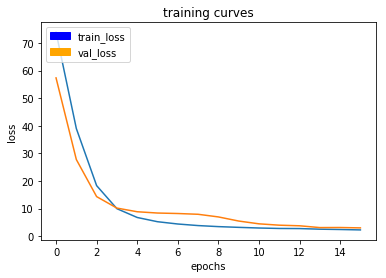

55/55 [==============================] - 61s 1s/step - loss: 2.2627 - val_loss: 2.9984
Epoch 17/200
54/55 [============================>.] - ETA: 1s - loss: 2.1293

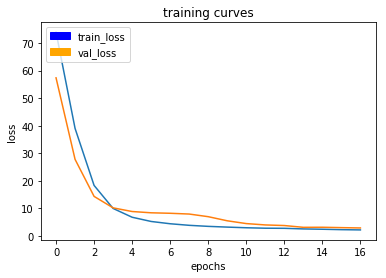

55/55 [==============================] - 60s 1s/step - loss: 2.1695 - val_loss: 2.8780
Epoch 18/200
54/55 [============================>.] - ETA: 1s - loss: 3.5504

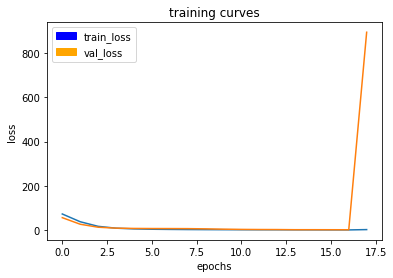

55/55 [==============================] - 61s 1s/step - loss: 3.6076 - val_loss: 892.3247
Epoch 19/200
54/55 [============================>.] - ETA: 1s - loss: 3.4378

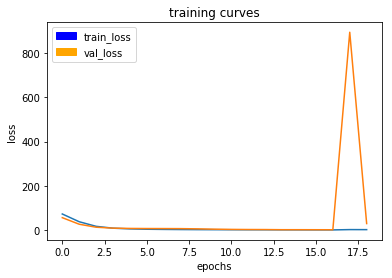

55/55 [==============================] - 61s 1s/step - loss: 3.4354 - val_loss: 30.7849
Epoch 20/200
54/55 [============================>.] - ETA: 1s - loss: 2.8984

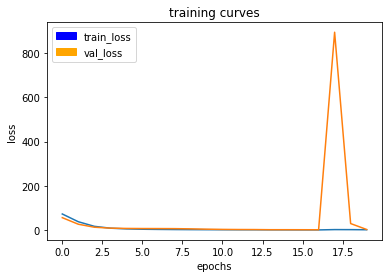

55/55 [==============================] - 60s 1s/step - loss: 2.8868 - val_loss: 4.1113
Epoch 21/200
54/55 [============================>.] - ETA: 1s - loss: 2.6356

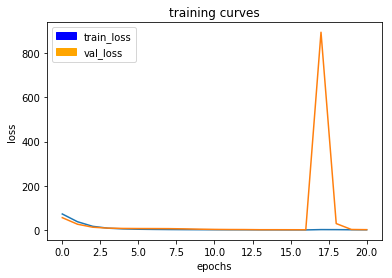

55/55 [==============================] - 61s 1s/step - loss: 2.6334 - val_loss: 3.3208
Epoch 22/200
54/55 [============================>.] - ETA: 1s - loss: 2.5051

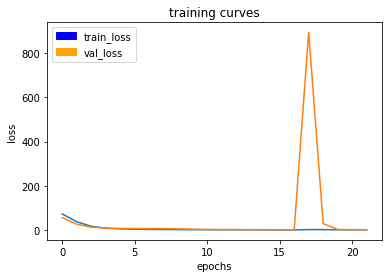

55/55 [==============================] - 60s 1s/step - loss: 2.5178 - val_loss: 3.0398
Epoch 23/200
54/55 [============================>.] - ETA: 1s - loss: 2.3612

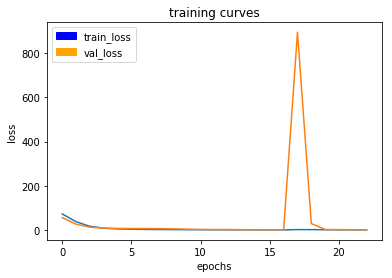

55/55 [==============================] - 61s 1s/step - loss: 2.3543 - val_loss: 2.8938
Epoch 24/200
54/55 [============================>.] - ETA: 1s - loss: 2.1978

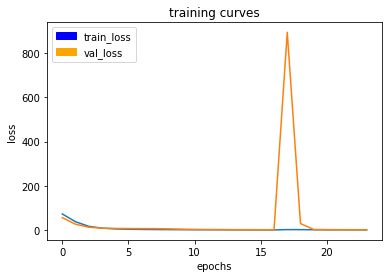

55/55 [==============================] - 61s 1s/step - loss: 2.2288 - val_loss: 3.0042
Epoch 25/200
54/55 [============================>.] - ETA: 1s - loss: 2.2103

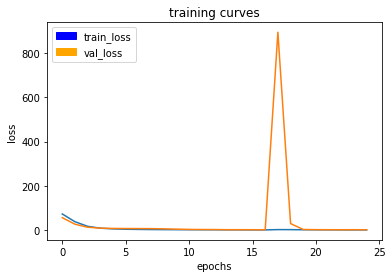

55/55 [==============================] - 61s 1s/step - loss: 2.2031 - val_loss: 2.8099
Epoch 26/200
54/55 [============================>.] - ETA: 1s - loss: 2.1248

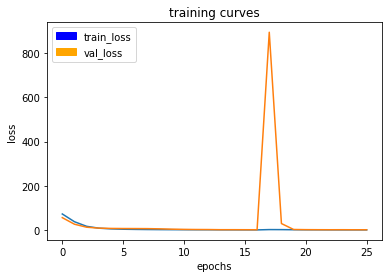

55/55 [==============================] - 61s 1s/step - loss: 2.1228 - val_loss: 2.7376
Epoch 27/200
54/55 [============================>.] - ETA: 1s - loss: 2.0289

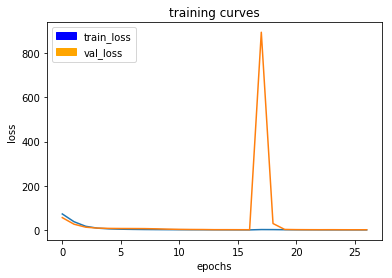

55/55 [==============================] - 60s 1s/step - loss: 2.0294 - val_loss: 2.7144
Epoch 28/200
54/55 [============================>.] - ETA: 1s - loss: 1.9963

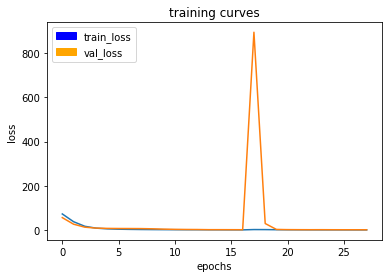

55/55 [==============================] - 61s 1s/step - loss: 2.0074 - val_loss: 2.5608
Epoch 29/200
54/55 [============================>.] - ETA: 1s - loss: 1.9584

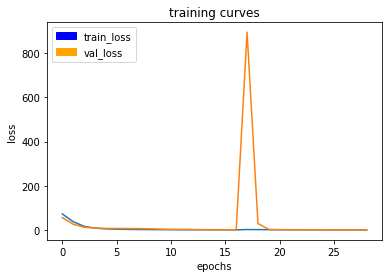

55/55 [==============================] - 60s 1s/step - loss: 1.9536 - val_loss: 2.5865
Epoch 30/200
54/55 [============================>.] - ETA: 1s - loss: 1.8482

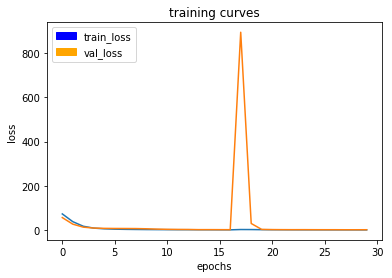

55/55 [==============================] - 61s 1s/step - loss: 1.8426 - val_loss: 2.6612
Epoch 31/200
54/55 [============================>.] - ETA: 1s - loss: 1.8361

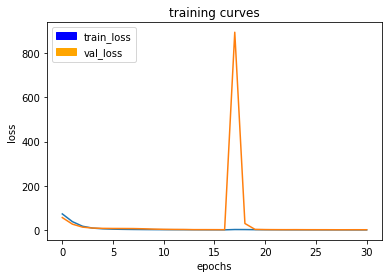

55/55 [==============================] - 61s 1s/step - loss: 1.8354 - val_loss: 2.6075
Epoch 32/200
54/55 [============================>.] - ETA: 1s - loss: 1.8099

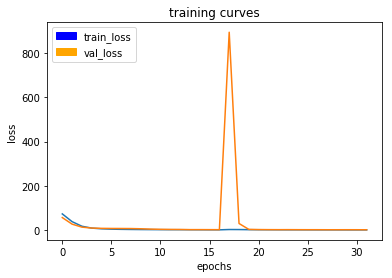

55/55 [==============================] - 61s 1s/step - loss: 1.8052 - val_loss: 2.4366
Epoch 33/200
54/55 [============================>.] - ETA: 1s - loss: 1.7406

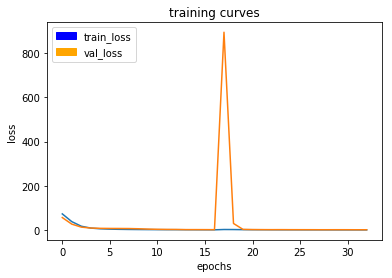

55/55 [==============================] - 61s 1s/step - loss: 1.7455 - val_loss: 2.4538
Epoch 34/200
54/55 [============================>.] - ETA: 1s - loss: 1.8809

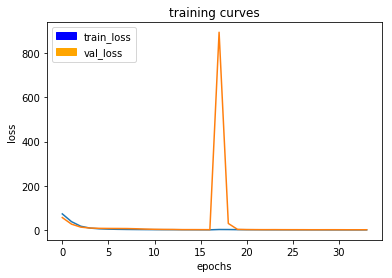

55/55 [==============================] - 61s 1s/step - loss: 1.8805 - val_loss: 2.5068
Epoch 35/200
54/55 [============================>.] - ETA: 1s - loss: 1.7185

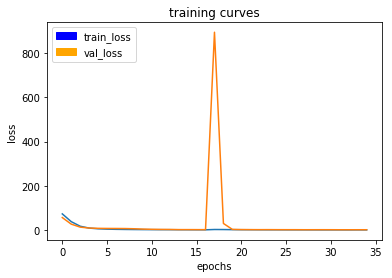

55/55 [==============================] - 61s 1s/step - loss: 1.7389 - val_loss: 2.5205
Epoch 36/200
54/55 [============================>.] - ETA: 1s - loss: 1.6508

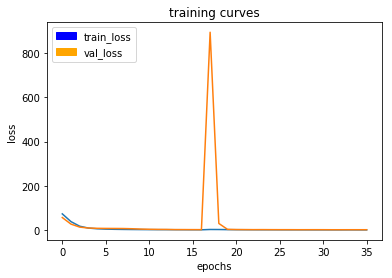

55/55 [==============================] - 61s 1s/step - loss: 1.6467 - val_loss: 2.5096
Epoch 37/200
54/55 [============================>.] - ETA: 1s - loss: 1.6255

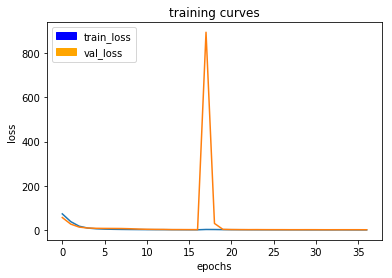

55/55 [==============================] - 61s 1s/step - loss: 1.6211 - val_loss: 2.3577
Epoch 38/200
54/55 [============================>.] - ETA: 1s - loss: 1.5316

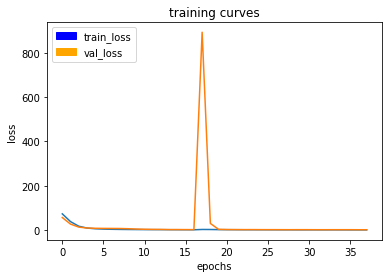

55/55 [==============================] - 61s 1s/step - loss: 1.5684 - val_loss: 2.3181
Epoch 39/200
54/55 [============================>.] - ETA: 1s - loss: 1.6410

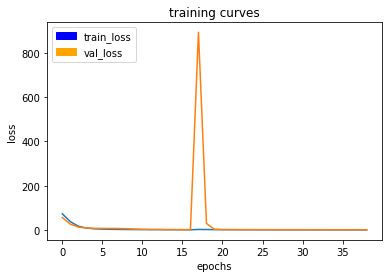

55/55 [==============================] - 61s 1s/step - loss: 1.6362 - val_loss: 2.3239
Epoch 40/200
54/55 [============================>.] - ETA: 1s - loss: 1.5742

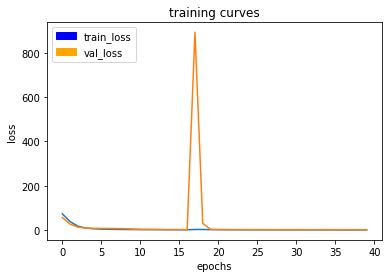

55/55 [==============================] - 61s 1s/step - loss: 1.5709 - val_loss: 2.4976
Epoch 41/200
54/55 [============================>.] - ETA: 1s - loss: 1.5049

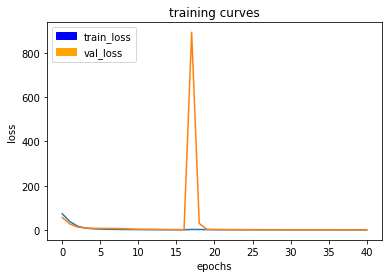

55/55 [==============================] - 62s 1s/step - loss: 1.5055 - val_loss: 2.4713
Epoch 42/200
54/55 [============================>.] - ETA: 1s - loss: 1.6072

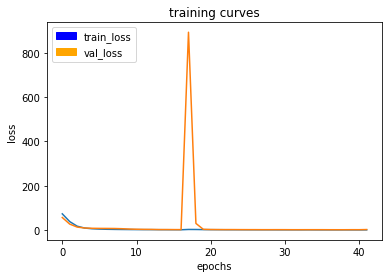

55/55 [==============================] - 61s 1s/step - loss: 1.6086 - val_loss: 3.1633
Epoch 43/200
54/55 [============================>.] - ETA: 1s - loss: 1.5207

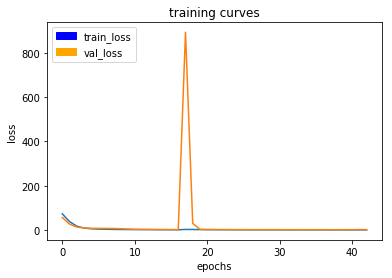

55/55 [==============================] - 60s 1s/step - loss: 1.5169 - val_loss: 2.4072
Epoch 44/200
54/55 [============================>.] - ETA: 1s - loss: 1.4971

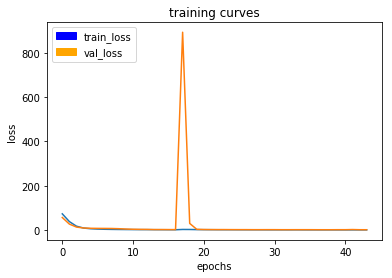

55/55 [==============================] - 61s 1s/step - loss: 1.4964 - val_loss: 2.2883
Epoch 45/200
54/55 [============================>.] - ETA: 1s - loss: 1.4167

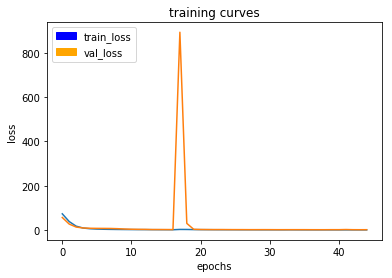

55/55 [==============================] - 60s 1s/step - loss: 1.4142 - val_loss: 2.3697
Epoch 46/200
54/55 [============================>.] - ETA: 1s - loss: 1.4412

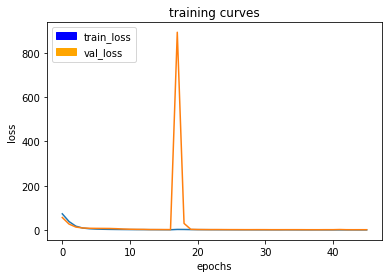

55/55 [==============================] - 62s 1s/step - loss: 1.4423 - val_loss: 2.3251
Epoch 47/200
54/55 [============================>.] - ETA: 1s - loss: 1.4821

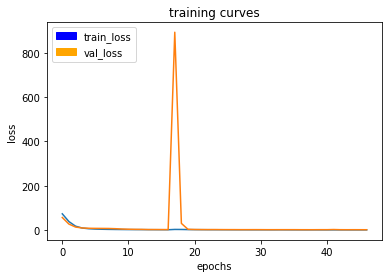

55/55 [==============================] - 61s 1s/step - loss: 1.4798 - val_loss: 2.2346
Epoch 48/200
54/55 [============================>.] - ETA: 1s - loss: 1.3925

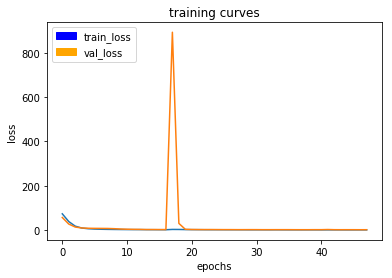

55/55 [==============================] - 61s 1s/step - loss: 1.3884 - val_loss: 2.2936
Epoch 49/200
54/55 [============================>.] - ETA: 1s - loss: 1.3525

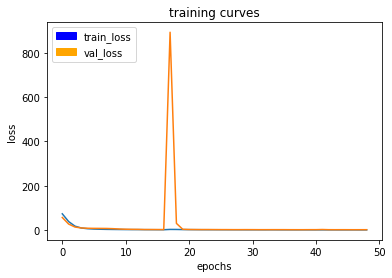

55/55 [==============================] - 61s 1s/step - loss: 1.3566 - val_loss: 2.3366
Epoch 50/200
54/55 [============================>.] - ETA: 1s - loss: 1.3586

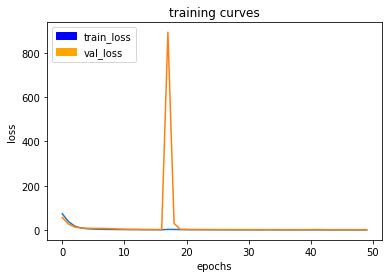

55/55 [==============================] - 61s 1s/step - loss: 1.3581 - val_loss: 2.1906
Epoch 51/200
54/55 [============================>.] - ETA: 1s - loss: 1.3093

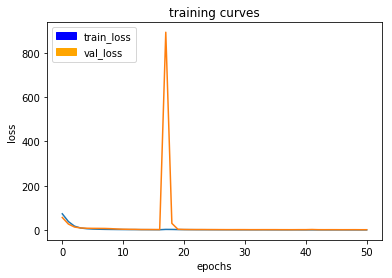

55/55 [==============================] - 61s 1s/step - loss: 1.3069 - val_loss: 2.1905
Epoch 52/200
54/55 [============================>.] - ETA: 1s - loss: 1.4551

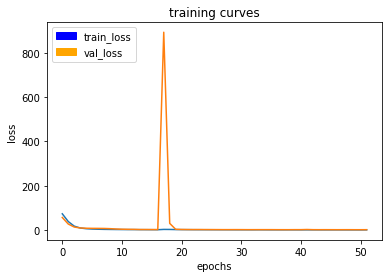

55/55 [==============================] - 61s 1s/step - loss: 1.4523 - val_loss: 2.3171
Epoch 53/200
54/55 [============================>.] - ETA: 1s - loss: 1.3733

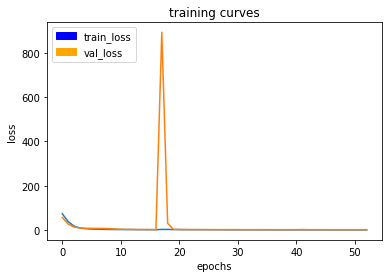

55/55 [==============================] - 61s 1s/step - loss: 1.3722 - val_loss: 2.4634
Epoch 54/200
54/55 [============================>.] - ETA: 1s - loss: 1.4289

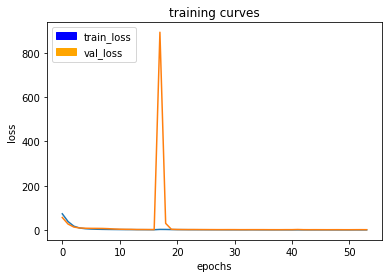

55/55 [==============================] - 61s 1s/step - loss: 1.4285 - val_loss: 2.2837
Epoch 55/200
54/55 [============================>.] - ETA: 1s - loss: 1.4263

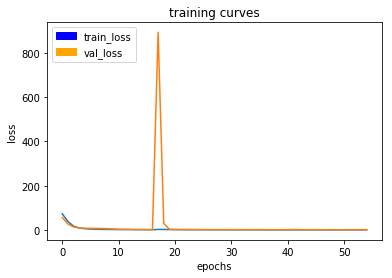

55/55 [==============================] - 61s 1s/step - loss: 1.4259 - val_loss: 2.4228
Epoch 56/200
54/55 [============================>.] - ETA: 1s - loss: 1.3571

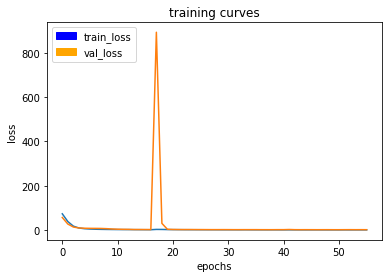

55/55 [==============================] - 61s 1s/step - loss: 1.3548 - val_loss: 2.2546
Epoch 57/200
54/55 [============================>.] - ETA: 1s - loss: 1.2464

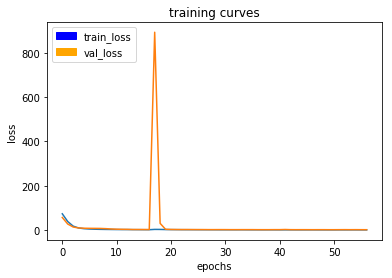

55/55 [==============================] - 61s 1s/step - loss: 1.2489 - val_loss: 2.1637
Epoch 58/200
54/55 [============================>.] - ETA: 1s - loss: 1.2999

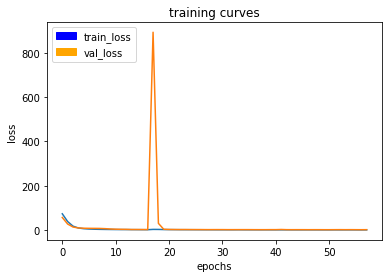

55/55 [==============================] - 61s 1s/step - loss: 1.2999 - val_loss: 2.3295
Epoch 59/200
54/55 [============================>.] - ETA: 1s - loss: 1.2289

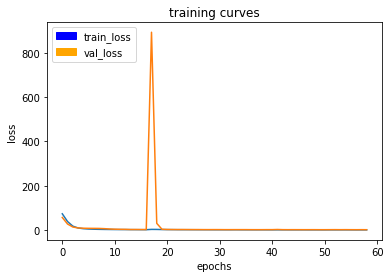

55/55 [==============================] - 61s 1s/step - loss: 1.2293 - val_loss: 2.1684
Epoch 60/200
54/55 [============================>.] - ETA: 1s - loss: 1.2027

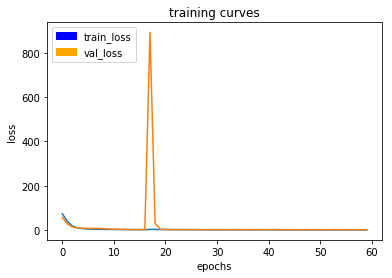

55/55 [==============================] - 61s 1s/step - loss: 1.2010 - val_loss: 2.2488
Epoch 61/200
54/55 [============================>.] - ETA: 1s - loss: 1.2014

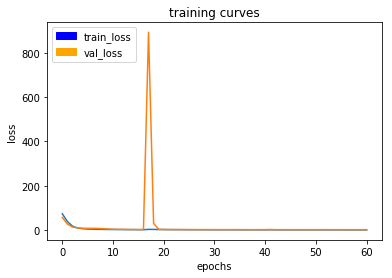

55/55 [==============================] - 61s 1s/step - loss: 1.2005 - val_loss: 2.2460
Epoch 62/200
54/55 [============================>.] - ETA: 1s - loss: 1.2698

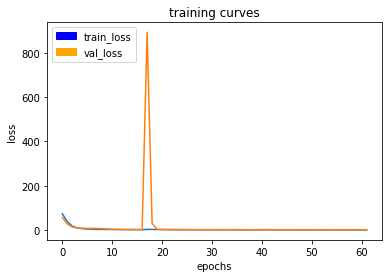

55/55 [==============================] - 62s 1s/step - loss: 1.2774 - val_loss: 2.4830
Epoch 63/200
54/55 [============================>.] - ETA: 1s - loss: 1.3392

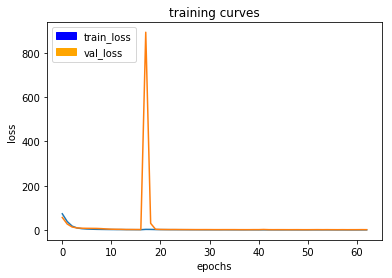

55/55 [==============================] - 61s 1s/step - loss: 1.3417 - val_loss: 2.2859
Epoch 64/200
54/55 [============================>.] - ETA: 1s - loss: 1.2810

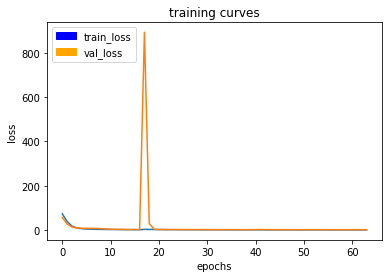

55/55 [==============================] - 61s 1s/step - loss: 1.2806 - val_loss: 2.1204
Epoch 65/200
54/55 [============================>.] - ETA: 1s - loss: 1.2024

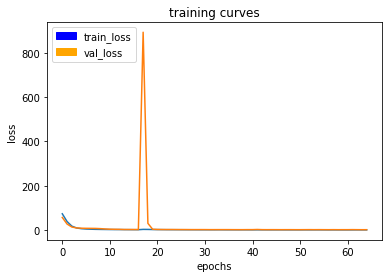

55/55 [==============================] - 61s 1s/step - loss: 1.1992 - val_loss: 2.1485
Epoch 66/200
54/55 [============================>.] - ETA: 1s - loss: 1.1500

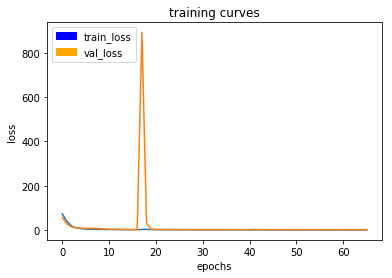

55/55 [==============================] - 61s 1s/step - loss: 1.1533 - val_loss: 2.6951
Epoch 67/200
54/55 [============================>.] - ETA: 1s - loss: 1.1607

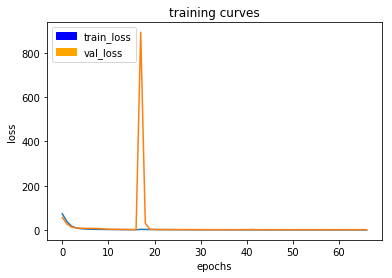

55/55 [==============================] - 61s 1s/step - loss: 1.1666 - val_loss: 2.2265
Epoch 68/200
54/55 [============================>.] - ETA: 1s - loss: 1.1331

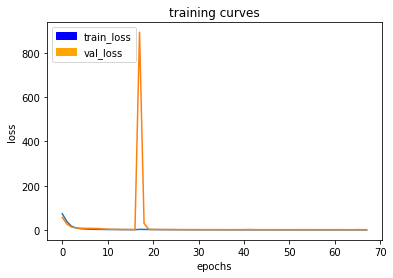

55/55 [==============================] - 61s 1s/step - loss: 1.1328 - val_loss: 2.1548
Epoch 69/200
54/55 [============================>.] - ETA: 1s - loss: 1.1408

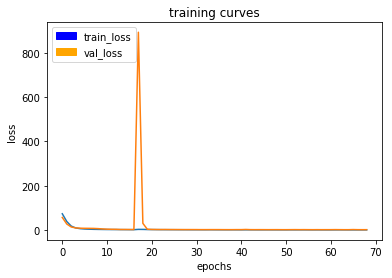

55/55 [==============================] - 61s 1s/step - loss: 1.1410 - val_loss: 2.2182
Epoch 70/200
54/55 [============================>.] - ETA: 1s - loss: 1.0842

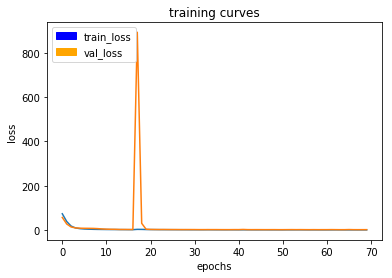

55/55 [==============================] - 60s 1s/step - loss: 1.0825 - val_loss: 2.2428
Epoch 71/200
54/55 [============================>.] - ETA: 1s - loss: 1.0707

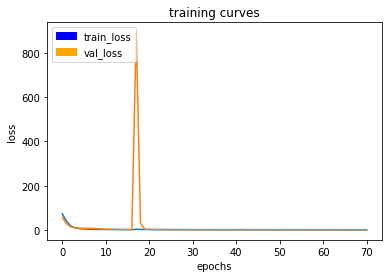

55/55 [==============================] - 61s 1s/step - loss: 1.0707 - val_loss: 2.3660
Epoch 72/200
54/55 [============================>.] - ETA: 1s - loss: 1.2574

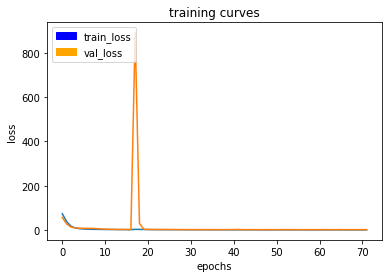

55/55 [==============================] - 62s 1s/step - loss: 1.2546 - val_loss: 2.3950
Epoch 73/200
54/55 [============================>.] - ETA: 1s - loss: 1.1207

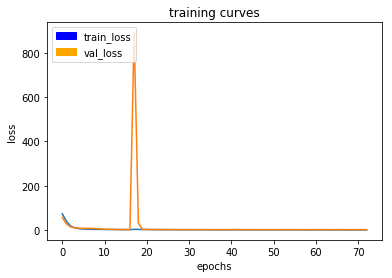

55/55 [==============================] - 61s 1s/step - loss: 1.1184 - val_loss: 2.2500
Epoch 74/200
54/55 [============================>.] - ETA: 1s - loss: 1.2504

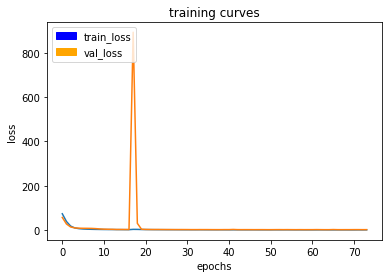

55/55 [==============================] - 61s 1s/step - loss: 1.2499 - val_loss: 2.3067
Epoch 75/200
54/55 [============================>.] - ETA: 1s - loss: 1.2195

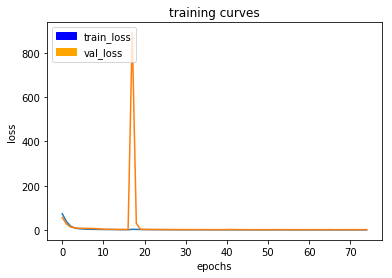

55/55 [==============================] - 60s 1s/step - loss: 1.2176 - val_loss: 2.6294
Epoch 76/200
54/55 [============================>.] - ETA: 1s - loss: 1.1737

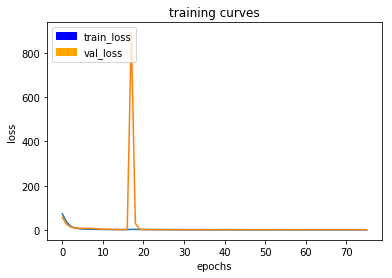

55/55 [==============================] - 60s 1s/step - loss: 1.1701 - val_loss: 2.2053
Epoch 77/200
54/55 [============================>.] - ETA: 1s - loss: 1.1179

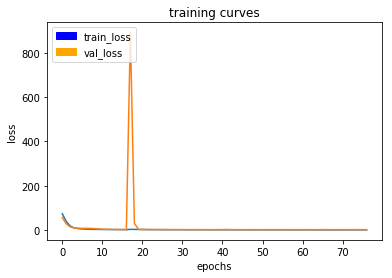

55/55 [==============================] - 61s 1s/step - loss: 1.1192 - val_loss: 2.2153
Epoch 78/200
54/55 [============================>.] - ETA: 1s - loss: 1.0656

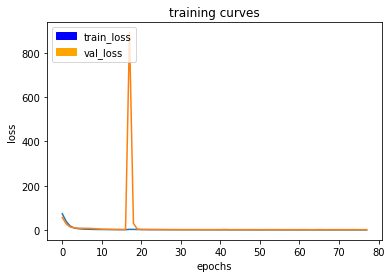

55/55 [==============================] - 60s 1s/step - loss: 1.0654 - val_loss: 2.2029
Epoch 79/200
54/55 [============================>.] - ETA: 1s - loss: 1.0190

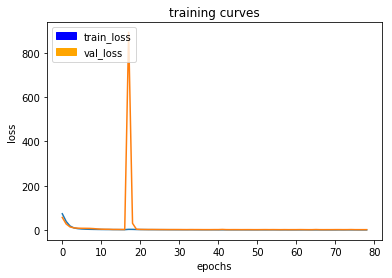

55/55 [==============================] - 62s 1s/step - loss: 1.0187 - val_loss: 2.2046
Epoch 80/200
54/55 [============================>.] - ETA: 1s - loss: 1.0417

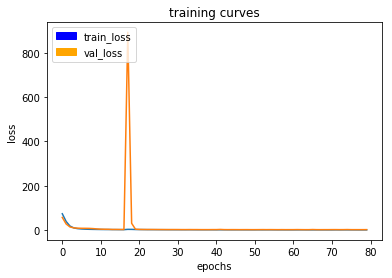

55/55 [==============================] - 61s 1s/step - loss: 1.0424 - val_loss: 2.3056
Epoch 81/200
54/55 [============================>.] - ETA: 1s - loss: 1.0382

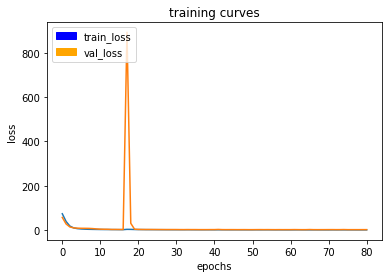

55/55 [==============================] - 60s 1s/step - loss: 1.0363 - val_loss: 2.2959
Epoch 82/200
54/55 [============================>.] - ETA: 1s - loss: 0.9978

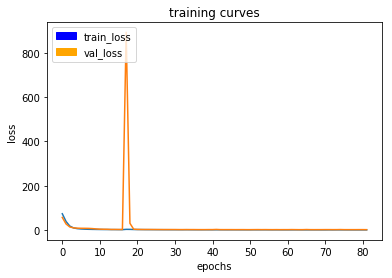

55/55 [==============================] - 61s 1s/step - loss: 0.9970 - val_loss: 2.1190
Epoch 83/200
54/55 [============================>.] - ETA: 1s - loss: 1.0180

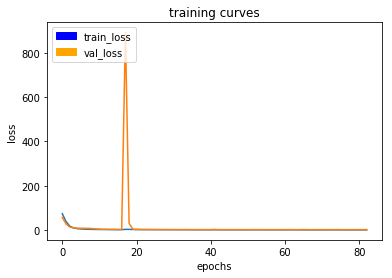

55/55 [==============================] - 61s 1s/step - loss: 1.0111 - val_loss: 2.3197
Epoch 84/200
54/55 [============================>.] - ETA: 1s - loss: 1.0218

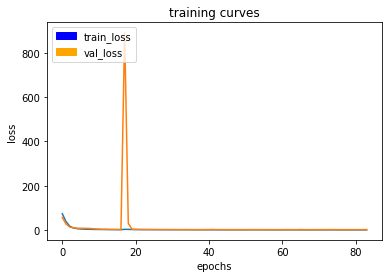

55/55 [==============================] - 61s 1s/step - loss: 1.0228 - val_loss: 2.5050
Epoch 85/200
54/55 [============================>.] - ETA: 1s - loss: 1.0203

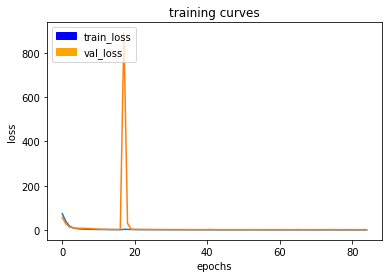

55/55 [==============================] - 61s 1s/step - loss: 1.0209 - val_loss: 2.2431
Epoch 86/200
54/55 [============================>.] - ETA: 1s - loss: 1.0070

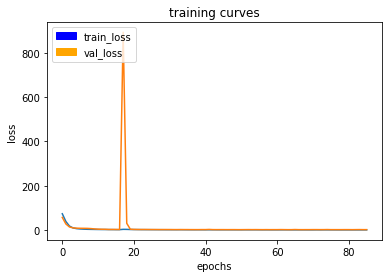

55/55 [==============================] - 61s 1s/step - loss: 1.0052 - val_loss: 2.2508
Epoch 87/200
54/55 [============================>.] - ETA: 1s - loss: 0.9951

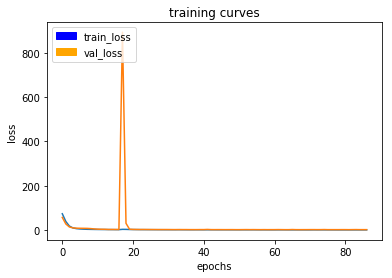

55/55 [==============================] - 61s 1s/step - loss: 0.9917 - val_loss: 2.1954
Epoch 88/200
54/55 [============================>.] - ETA: 1s - loss: 0.9733

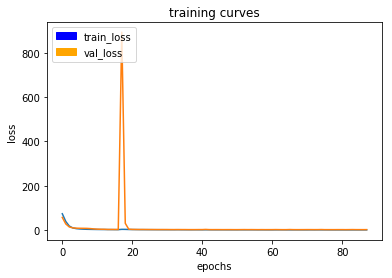

55/55 [==============================] - 61s 1s/step - loss: 0.9725 - val_loss: 2.2816
Epoch 89/200
54/55 [============================>.] - ETA: 1s - loss: 0.9546

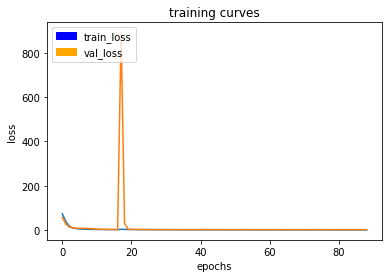

55/55 [==============================] - 60s 1s/step - loss: 0.9555 - val_loss: 2.3393
Epoch 90/200
54/55 [============================>.] - ETA: 1s - loss: 1.1409

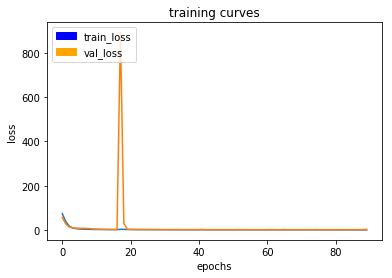

55/55 [==============================] - 61s 1s/step - loss: 1.1412 - val_loss: 3.6703
Epoch 91/200
54/55 [============================>.] - ETA: 1s - loss: 1.4428

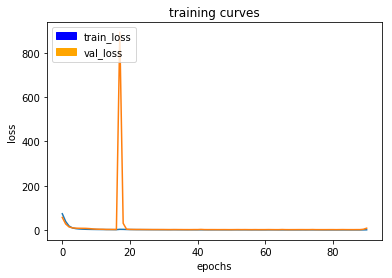

55/55 [==============================] - 60s 1s/step - loss: 1.4417 - val_loss: 8.7579
Epoch 92/200
54/55 [============================>.] - ETA: 1s - loss: 1.4062

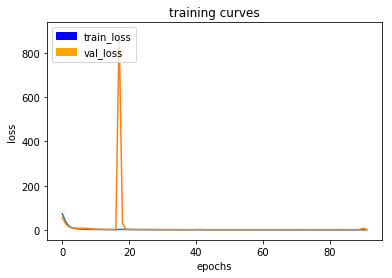

55/55 [==============================] - 61s 1s/step - loss: 1.4025 - val_loss: 2.4348
Epoch 93/200
54/55 [============================>.] - ETA: 1s - loss: 1.1025

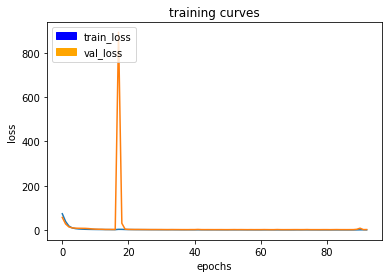

55/55 [==============================] - 61s 1s/step - loss: 1.1036 - val_loss: 2.5989
Epoch 94/200
54/55 [============================>.] - ETA: 1s - loss: 1.0592

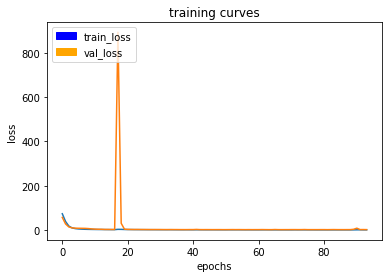

55/55 [==============================] - 61s 1s/step - loss: 1.0597 - val_loss: 2.2679
Epoch 95/200
54/55 [============================>.] - ETA: 1s - loss: 0.9918

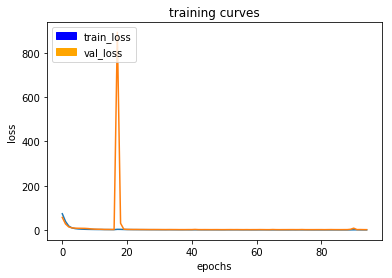

55/55 [==============================] - 60s 1s/step - loss: 0.9893 - val_loss: 2.1169
Epoch 96/200
54/55 [============================>.] - ETA: 1s - loss: 0.9526

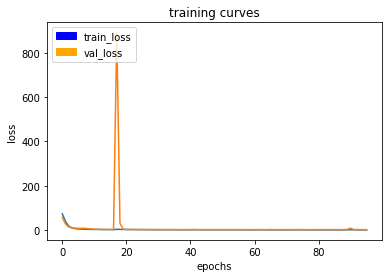

55/55 [==============================] - 61s 1s/step - loss: 0.9525 - val_loss: 2.2502
Epoch 97/200
54/55 [============================>.] - ETA: 1s - loss: 0.9428

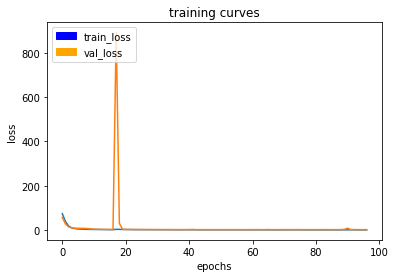

55/55 [==============================] - 61s 1s/step - loss: 0.9428 - val_loss: 2.2105
Epoch 98/200
54/55 [============================>.] - ETA: 1s - loss: 0.9483

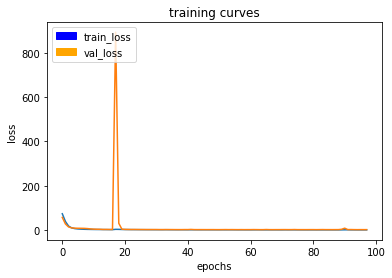

55/55 [==============================] - 62s 1s/step - loss: 0.9464 - val_loss: 2.2288
Epoch 99/200
54/55 [============================>.] - ETA: 1s - loss: 0.9313

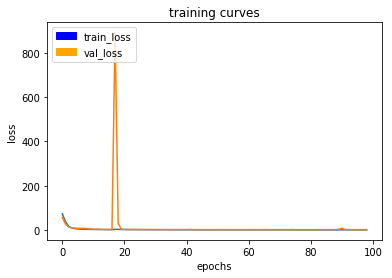

55/55 [==============================] - 60s 1s/step - loss: 0.9344 - val_loss: 2.2296
Epoch 100/200
54/55 [============================>.] - ETA: 1s - loss: 0.9256

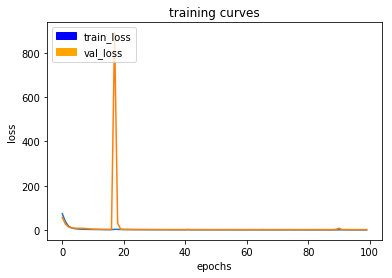

55/55 [==============================] - 60s 1s/step - loss: 0.9270 - val_loss: 2.3298
Epoch 101/200
54/55 [============================>.] - ETA: 1s - loss: 0.9540

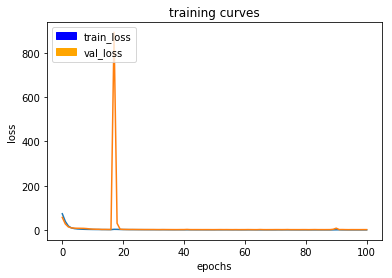

55/55 [==============================] - 61s 1s/step - loss: 0.9513 - val_loss: 2.2451
Epoch 102/200
54/55 [============================>.] - ETA: 1s - loss: 0.9170

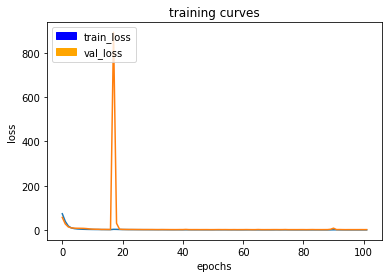

55/55 [==============================] - 61s 1s/step - loss: 0.9246 - val_loss: 2.2613
Epoch 103/200
54/55 [============================>.] - ETA: 1s - loss: 0.9091

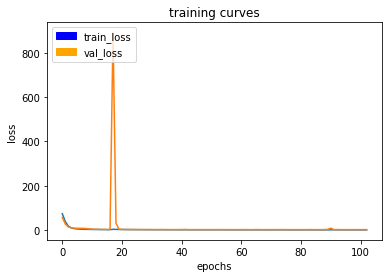

55/55 [==============================] - 60s 1s/step - loss: 0.9092 - val_loss: 2.2324
Epoch 104/200
54/55 [============================>.] - ETA: 1s - loss: 0.9217

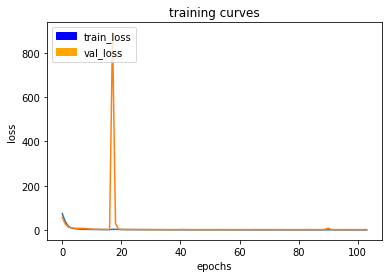

55/55 [==============================] - 61s 1s/step - loss: 0.9227 - val_loss: 2.5672
Epoch 105/200
54/55 [============================>.] - ETA: 1s - loss: 1.1330

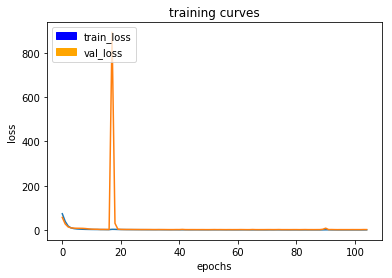

55/55 [==============================] - 61s 1s/step - loss: 1.1361 - val_loss: 2.4070
Epoch 106/200
54/55 [============================>.] - ETA: 1s - loss: 1.0752

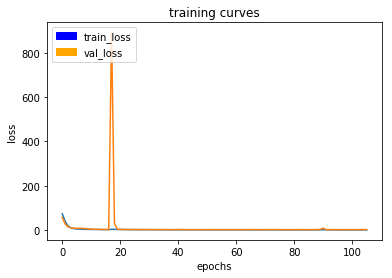

55/55 [==============================] - 61s 1s/step - loss: 1.0830 - val_loss: 2.7676
Epoch 107/200
54/55 [============================>.] - ETA: 1s - loss: 1.1672

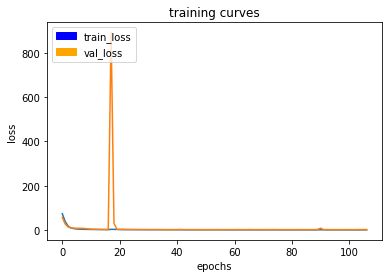

55/55 [==============================] - 61s 1s/step - loss: 1.1658 - val_loss: 2.2509
Epoch 108/200
54/55 [============================>.] - ETA: 1s - loss: 1.0388

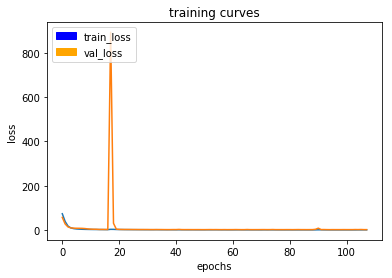

55/55 [==============================] - 61s 1s/step - loss: 1.0400 - val_loss: 2.2065
Epoch 109/200
54/55 [============================>.] - ETA: 1s - loss: 0.9388

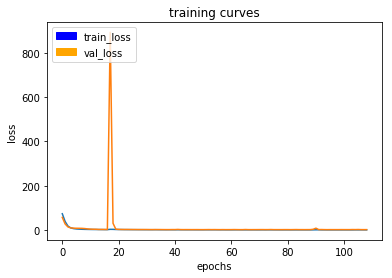

55/55 [==============================] - 62s 1s/step - loss: 0.9384 - val_loss: 2.2225
Epoch 110/200
54/55 [============================>.] - ETA: 1s - loss: 0.9382

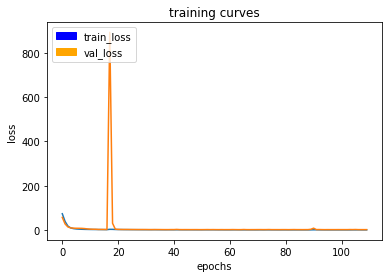

55/55 [==============================] - 62s 1s/step - loss: 0.9388 - val_loss: 2.2157
Epoch 111/200
54/55 [============================>.] - ETA: 1s - loss: 0.8900

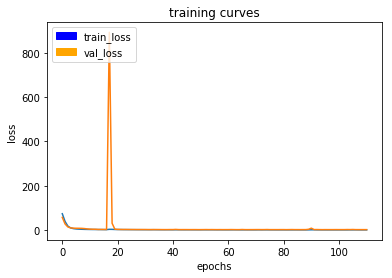

55/55 [==============================] - 61s 1s/step - loss: 0.8917 - val_loss: 2.1592
Epoch 112/200
54/55 [============================>.] - ETA: 1s - loss: 0.8846

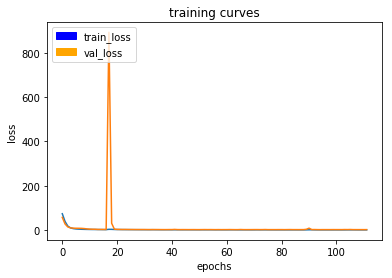

55/55 [==============================] - 61s 1s/step - loss: 0.8836 - val_loss: 2.2440
Epoch 113/200
54/55 [============================>.] - ETA: 1s - loss: 0.8665

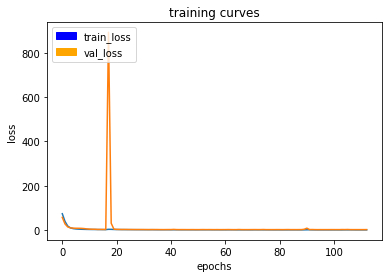

55/55 [==============================] - 61s 1s/step - loss: 0.8676 - val_loss: 2.2917
Epoch 114/200
54/55 [============================>.] - ETA: 1s - loss: 0.8530

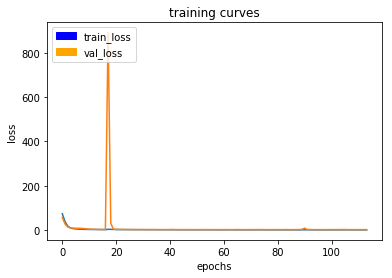

55/55 [==============================] - 61s 1s/step - loss: 0.8544 - val_loss: 2.2159
Epoch 115/200
54/55 [============================>.] - ETA: 1s - loss: 0.8489

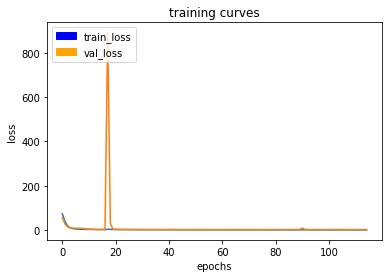

55/55 [==============================] - 61s 1s/step - loss: 0.8502 - val_loss: 2.3384
Epoch 116/200
54/55 [============================>.] - ETA: 1s - loss: 0.9265

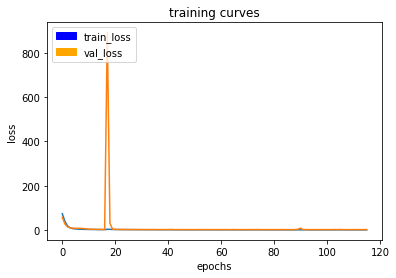

55/55 [==============================] - 61s 1s/step - loss: 0.9276 - val_loss: 2.4663
Epoch 117/200
54/55 [============================>.] - ETA: 1s - loss: 0.8816

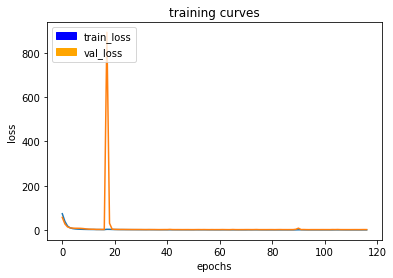

55/55 [==============================] - 61s 1s/step - loss: 0.8822 - val_loss: 2.3025
Epoch 118/200
54/55 [============================>.] - ETA: 1s - loss: 0.8783

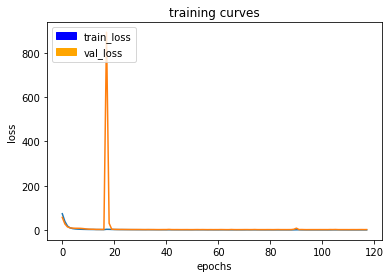

55/55 [==============================] - 62s 1s/step - loss: 0.8775 - val_loss: 2.3925
Epoch 119/200
54/55 [============================>.] - ETA: 1s - loss: 0.8777

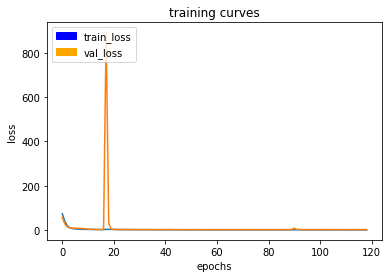

55/55 [==============================] - 61s 1s/step - loss: 0.8772 - val_loss: 2.4161
Epoch 120/200
54/55 [============================>.] - ETA: 1s - loss: 0.8678

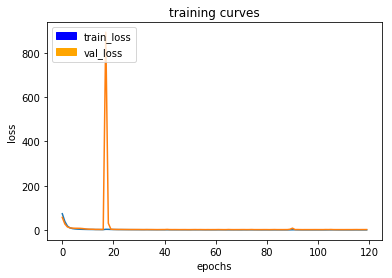

55/55 [==============================] - 61s 1s/step - loss: 0.8685 - val_loss: 2.4387
Epoch 121/200
54/55 [============================>.] - ETA: 1s - loss: 0.9397

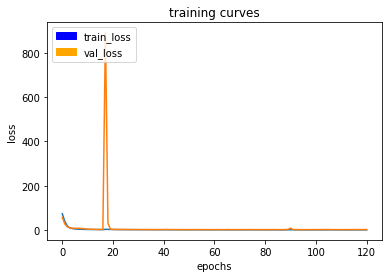

55/55 [==============================] - 61s 1s/step - loss: 0.9376 - val_loss: 2.5281
Epoch 122/200
54/55 [============================>.] - ETA: 1s - loss: 0.9557

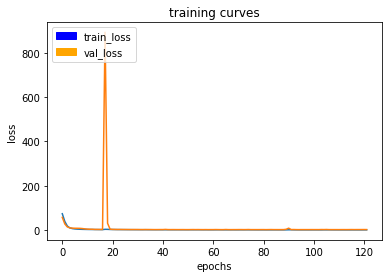

55/55 [==============================] - 61s 1s/step - loss: 0.9541 - val_loss: 2.3774
Epoch 123/200
54/55 [============================>.] - ETA: 1s - loss: 0.9693

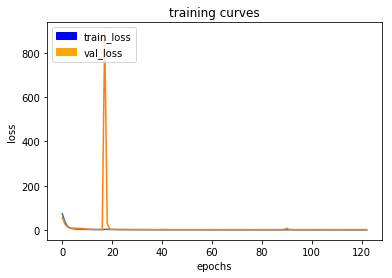

55/55 [==============================] - 61s 1s/step - loss: 0.9696 - val_loss: 2.2655
Epoch 124/200
54/55 [============================>.] - ETA: 1s - loss: 0.9555

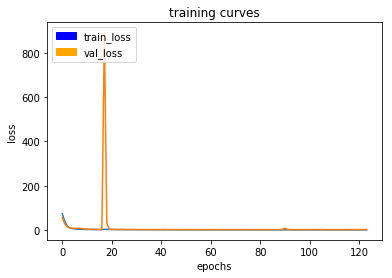

55/55 [==============================] - 60s 1s/step - loss: 0.9542 - val_loss: 2.7132
Epoch 125/200
54/55 [============================>.] - ETA: 1s - loss: 1.0388

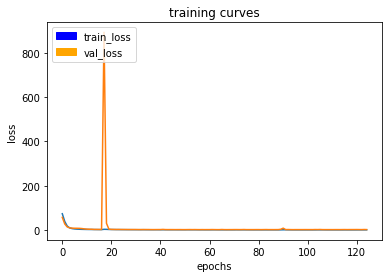

55/55 [==============================] - 35502s 645s/step - loss: 1.0430 - val_loss: 2.3533
Epoch 126/200
54/55 [============================>.] - ETA: 1s - loss: 0.9026

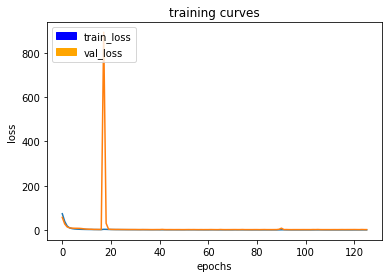

55/55 [==============================] - 63s 1s/step - loss: 0.9016 - val_loss: 2.2313
Epoch 127/200
54/55 [============================>.] - ETA: 1s - loss: 0.8649

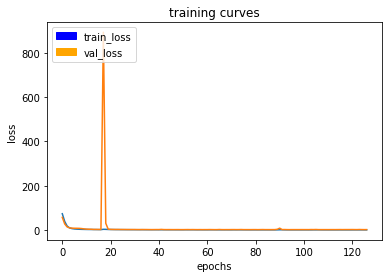

55/55 [==============================] - 61s 1s/step - loss: 0.8637 - val_loss: 2.2809
Epoch 128/200
54/55 [============================>.] - ETA: 1s - loss: 0.8422

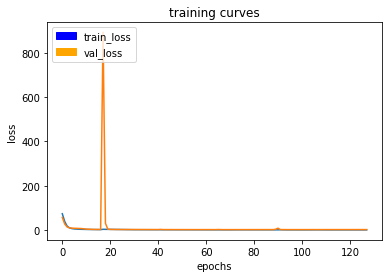

55/55 [==============================] - 60s 1s/step - loss: 0.8428 - val_loss: 2.3222
Epoch 129/200
54/55 [============================>.] - ETA: 1s - loss: 0.8168

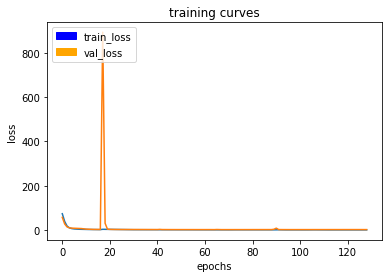

55/55 [==============================] - 62s 1s/step - loss: 0.8180 - val_loss: 2.2707
Epoch 130/200
54/55 [============================>.] - ETA: 1s - loss: 0.8188

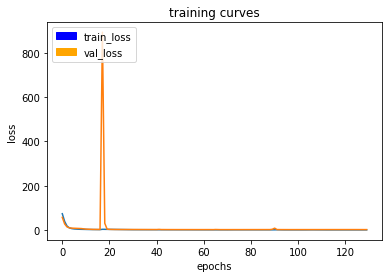

55/55 [==============================] - 61s 1s/step - loss: 0.8199 - val_loss: 2.2637
Epoch 131/200
54/55 [============================>.] - ETA: 1s - loss: 0.8068

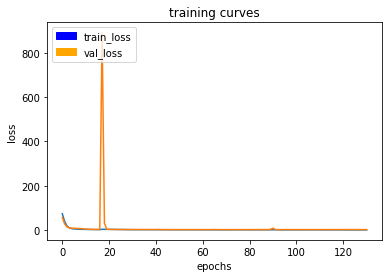

55/55 [==============================] - 60s 1s/step - loss: 0.8081 - val_loss: 2.3314
Epoch 132/200
54/55 [============================>.] - ETA: 1s - loss: 0.8051

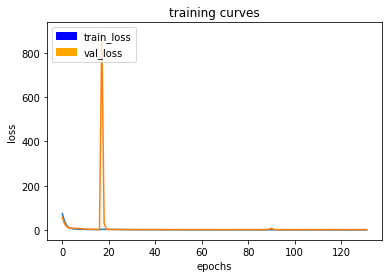

55/55 [==============================] - 60s 1s/step - loss: 0.8040 - val_loss: 2.3393
Epoch 133/200
54/55 [============================>.] - ETA: 1s - loss: 0.8059

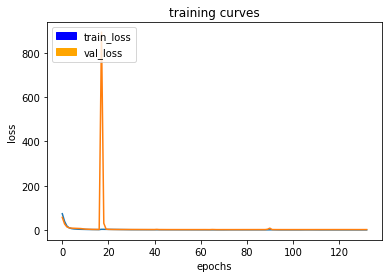

55/55 [==============================] - 60s 1s/step - loss: 0.8050 - val_loss: 2.3440
Epoch 134/200
54/55 [============================>.] - ETA: 1s - loss: 0.7980

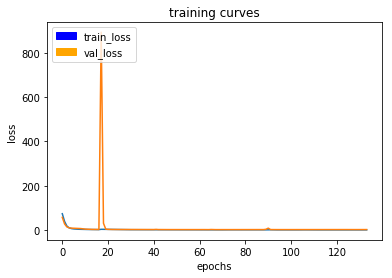

55/55 [==============================] - 61s 1s/step - loss: 0.7995 - val_loss: 2.3823
Epoch 135/200
54/55 [============================>.] - ETA: 1s - loss: 0.8122

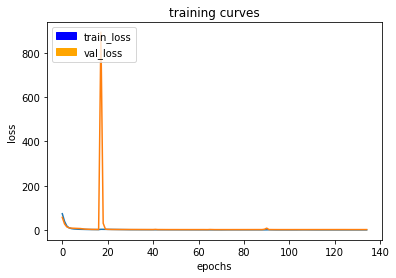

55/55 [==============================] - 61s 1s/step - loss: 0.8139 - val_loss: 2.3353
Epoch 136/200
54/55 [============================>.] - ETA: 1s - loss: 0.8189

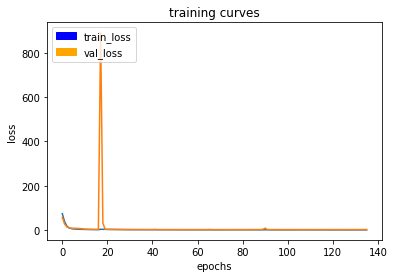

55/55 [==============================] - 61s 1s/step - loss: 0.8194 - val_loss: 2.5946
Epoch 137/200
54/55 [============================>.] - ETA: 1s - loss: 0.8036

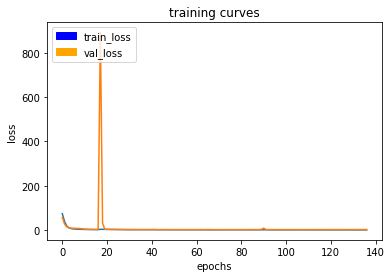

55/55 [==============================] - 60s 1s/step - loss: 0.8037 - val_loss: 2.4331
Epoch 138/200
54/55 [============================>.] - ETA: 1s - loss: 0.7810

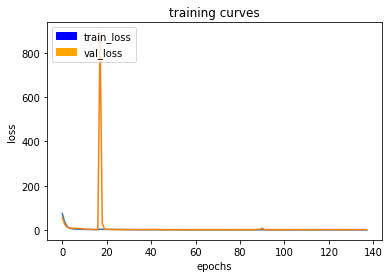

55/55 [==============================] - 61s 1s/step - loss: 0.7814 - val_loss: 2.4247
Epoch 139/200
54/55 [============================>.] - ETA: 1s - loss: 0.7911

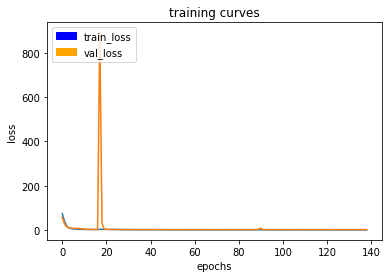

55/55 [==============================] - 60s 1s/step - loss: 0.7899 - val_loss: 2.3753
Epoch 140/200
54/55 [============================>.] - ETA: 1s - loss: 0.7730

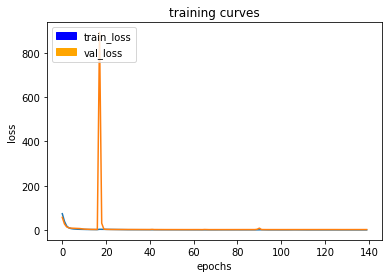

55/55 [==============================] - 60s 1s/step - loss: 0.7738 - val_loss: 2.3683
Epoch 141/200
54/55 [============================>.] - ETA: 1s - loss: 0.7763

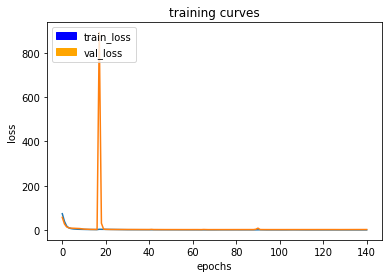

55/55 [==============================] - 60s 1s/step - loss: 0.7764 - val_loss: 2.5133
Epoch 142/200
54/55 [============================>.] - ETA: 1s - loss: 0.7676

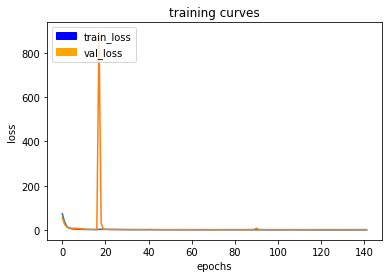

55/55 [==============================] - 60s 1s/step - loss: 0.7671 - val_loss: 2.4782
Epoch 143/200
54/55 [============================>.] - ETA: 1s - loss: 0.7695

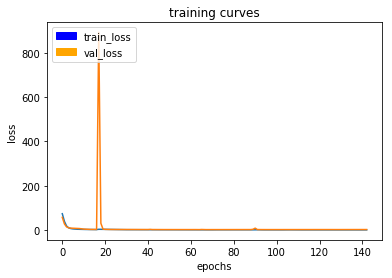

55/55 [==============================] - 60s 1s/step - loss: 0.7678 - val_loss: 2.4647
Epoch 144/200
54/55 [============================>.] - ETA: 1s - loss: 0.7767

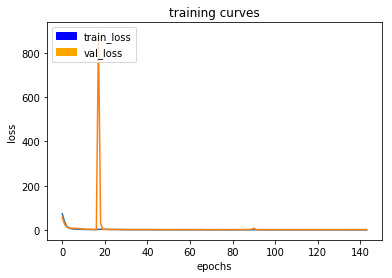

55/55 [==============================] - 60s 1s/step - loss: 0.7778 - val_loss: 2.4121
Epoch 145/200
54/55 [============================>.] - ETA: 0s - loss: 0.9135

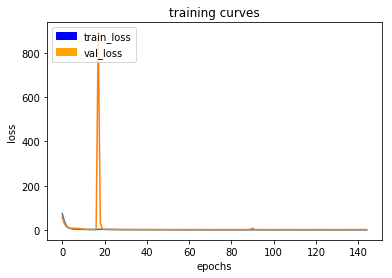

55/55 [==============================] - 60s 1s/step - loss: 0.9135 - val_loss: 2.4678
Epoch 146/200
54/55 [============================>.] - ETA: 1s - loss: 1.2275

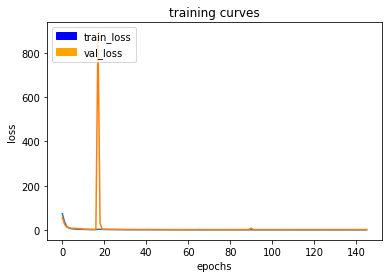

55/55 [==============================] - 60s 1s/step - loss: 1.2243 - val_loss: 2.7159
Epoch 147/200
54/55 [============================>.] - ETA: 1s - loss: 1.0751

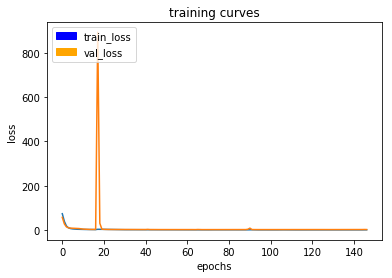

55/55 [==============================] - 60s 1s/step - loss: 1.0725 - val_loss: 2.4274
Epoch 148/200
54/55 [============================>.] - ETA: 1s - loss: 0.8824

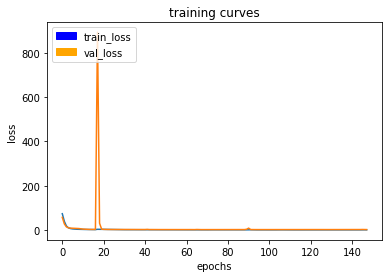

55/55 [==============================] - 60s 1s/step - loss: 0.8841 - val_loss: 2.3204
Epoch 149/200
54/55 [============================>.] - ETA: 1s - loss: 0.8263

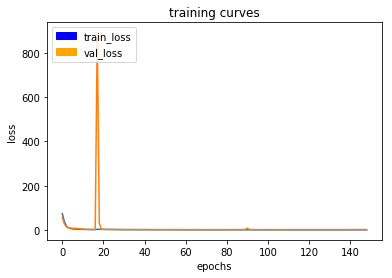

55/55 [==============================] - 60s 1s/step - loss: 0.8276 - val_loss: 2.3381
Epoch 150/200
54/55 [============================>.] - ETA: 1s - loss: 0.8100

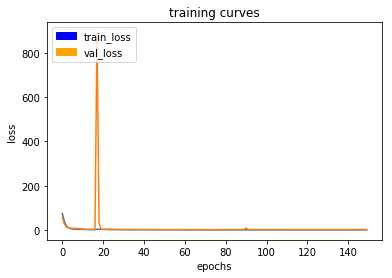

55/55 [==============================] - 61s 1s/step - loss: 0.8080 - val_loss: 2.4132
Epoch 151/200
54/55 [============================>.] - ETA: 1s - loss: 0.7986

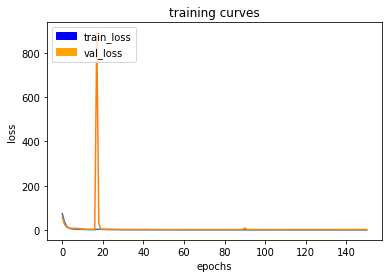

55/55 [==============================] - 60s 1s/step - loss: 0.7972 - val_loss: 2.4784
Epoch 152/200
54/55 [============================>.] - ETA: 1s - loss: 0.7852

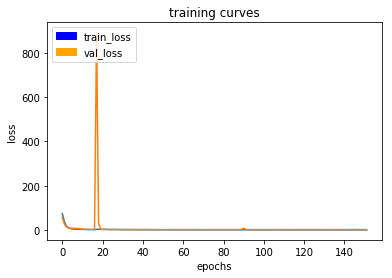

55/55 [==============================] - 61s 1s/step - loss: 0.7836 - val_loss: 2.4884
Epoch 153/200
54/55 [============================>.] - ETA: 1s - loss: 0.7763

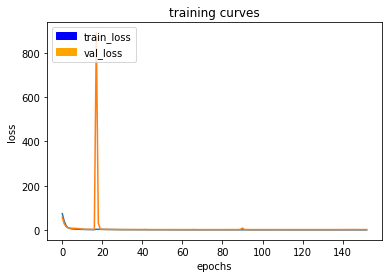

55/55 [==============================] - 61s 1s/step - loss: 0.7776 - val_loss: 2.4673
Epoch 154/200
54/55 [============================>.] - ETA: 1s - loss: 0.7754

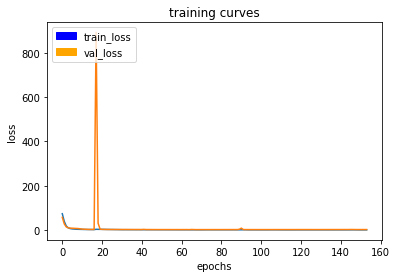

55/55 [==============================] - 61s 1s/step - loss: 0.7761 - val_loss: 2.4117
Epoch 155/200
54/55 [============================>.] - ETA: 1s - loss: 0.7636

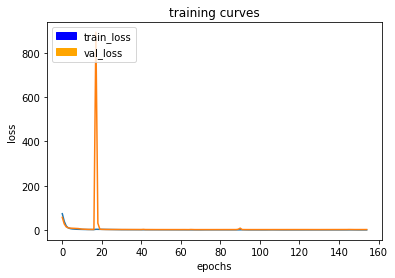

55/55 [==============================] - 61s 1s/step - loss: 0.7628 - val_loss: 2.4257
Epoch 156/200
54/55 [============================>.] - ETA: 1s - loss: 0.7576

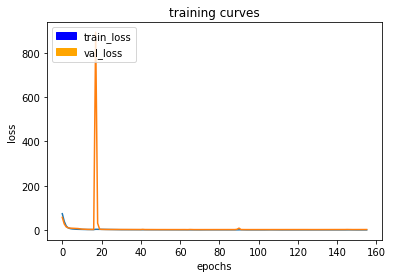

55/55 [==============================] - 61s 1s/step - loss: 0.7568 - val_loss: 2.4949
Epoch 157/200
54/55 [============================>.] - ETA: 1s - loss: 0.7484

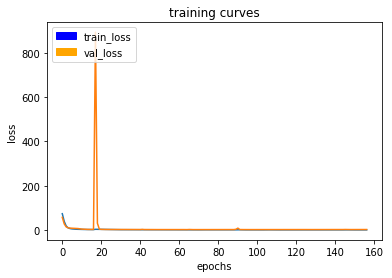

55/55 [==============================] - 60s 1s/step - loss: 0.7489 - val_loss: 2.5485
Epoch 158/200
54/55 [============================>.] - ETA: 1s - loss: 0.7504

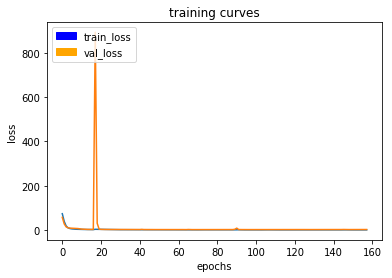

55/55 [==============================] - 61s 1s/step - loss: 0.7503 - val_loss: 2.5689
Epoch 159/200
54/55 [============================>.] - ETA: 1s - loss: 0.7413

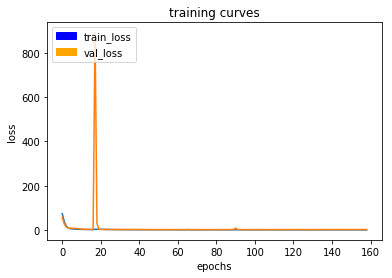

55/55 [==============================] - 60s 1s/step - loss: 0.7399 - val_loss: 2.5343
Epoch 160/200
54/55 [============================>.] - ETA: 1s - loss: 0.7433

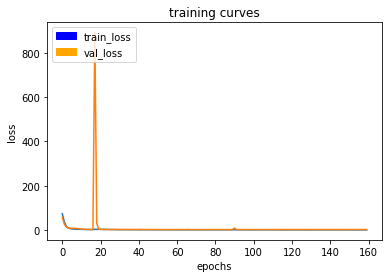

55/55 [==============================] - 61s 1s/step - loss: 0.7477 - val_loss: 2.5117
Epoch 161/200
54/55 [============================>.] - ETA: 1s - loss: 0.7406

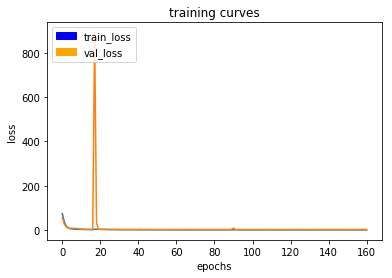

55/55 [==============================] - 60s 1s/step - loss: 0.7427 - val_loss: 2.5652
Epoch 162/200
54/55 [============================>.] - ETA: 1s - loss: 0.7377

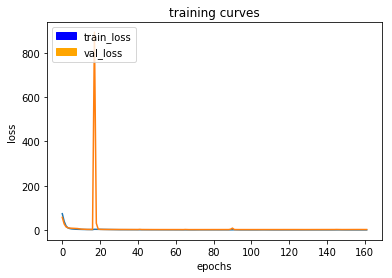

55/55 [==============================] - 60s 1s/step - loss: 0.7367 - val_loss: 2.4729
Epoch 163/200
54/55 [============================>.] - ETA: 1s - loss: 0.7404

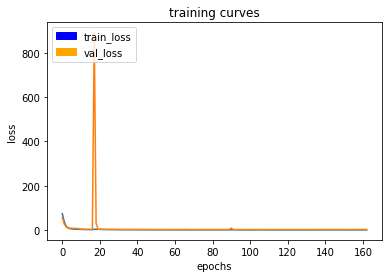

55/55 [==============================] - 60s 1s/step - loss: 0.7424 - val_loss: 2.7291
Epoch 164/200
54/55 [============================>.] - ETA: 1s - loss: 0.8224

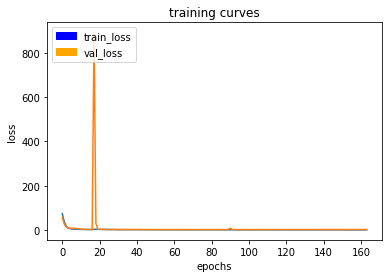

55/55 [==============================] - 61s 1s/step - loss: 0.8292 - val_loss: 2.8480
Epoch 165/200
54/55 [============================>.] - ETA: 1s - loss: 1.0402

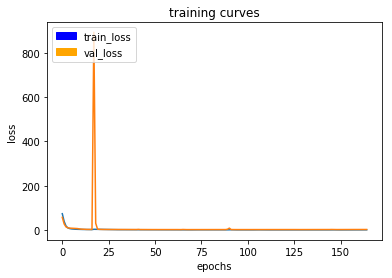

55/55 [==============================] - 60s 1s/step - loss: 1.0396 - val_loss: 2.6546
Epoch 166/200
54/55 [============================>.] - ETA: 1s - loss: 1.0456

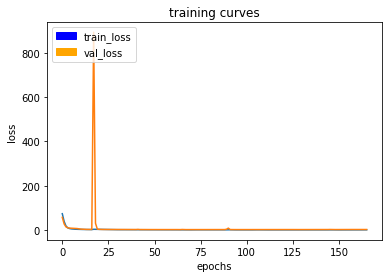

55/55 [==============================] - 60s 1s/step - loss: 1.0464 - val_loss: 2.5922
Epoch 167/200
54/55 [============================>.] - ETA: 1s - loss: 0.8584

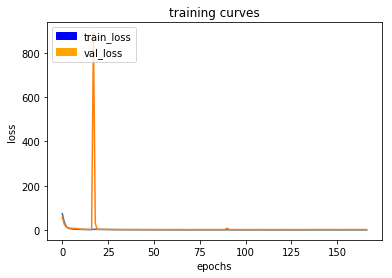

55/55 [==============================] - 61s 1s/step - loss: 0.8664 - val_loss: 2.3121
Epoch 168/200
54/55 [============================>.] - ETA: 1s - loss: 1.0217

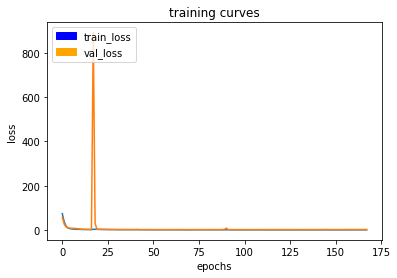

55/55 [==============================] - 61s 1s/step - loss: 1.0180 - val_loss: 2.6820
Epoch 169/200
54/55 [============================>.] - ETA: 1s - loss: 0.8330

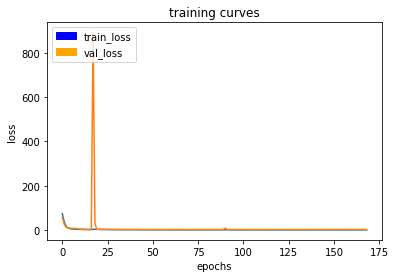

55/55 [==============================] - 60s 1s/step - loss: 0.8333 - val_loss: 2.3862
Epoch 170/200
54/55 [============================>.] - ETA: 1s - loss: 0.7955

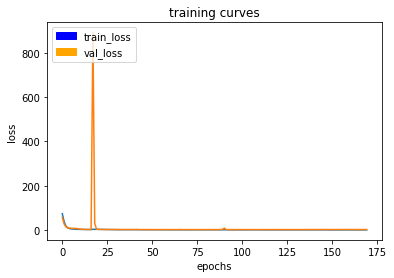

55/55 [==============================] - 60s 1s/step - loss: 0.7966 - val_loss: 2.7340
Epoch 171/200
54/55 [============================>.] - ETA: 1s - loss: 0.8858

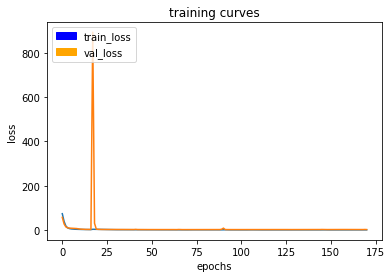

55/55 [==============================] - 61s 1s/step - loss: 0.8853 - val_loss: 2.3123
Epoch 172/200
54/55 [============================>.] - ETA: 1s - loss: 0.7994

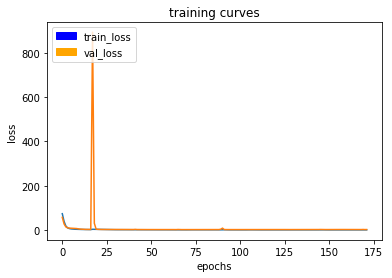

55/55 [==============================] - 60s 1s/step - loss: 0.7989 - val_loss: 2.4138
Epoch 173/200
54/55 [============================>.] - ETA: 1s - loss: 0.7541

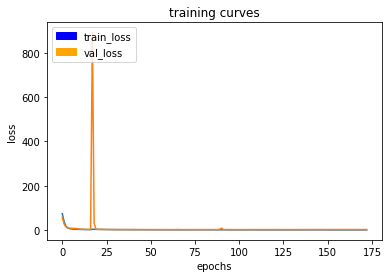

55/55 [==============================] - 61s 1s/step - loss: 0.7523 - val_loss: 2.4647
Epoch 174/200
54/55 [============================>.] - ETA: 1s - loss: 0.7410

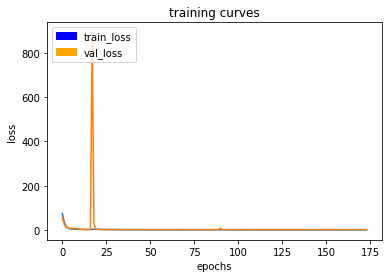

55/55 [==============================] - 61s 1s/step - loss: 0.7426 - val_loss: 2.4999
Epoch 175/200
54/55 [============================>.] - ETA: 1s - loss: 0.7328

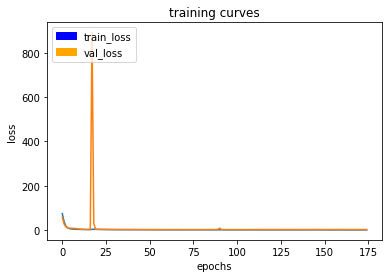

55/55 [==============================] - 60s 1s/step - loss: 0.7331 - val_loss: 2.4787
Epoch 176/200
54/55 [============================>.] - ETA: 1s - loss: 0.7313

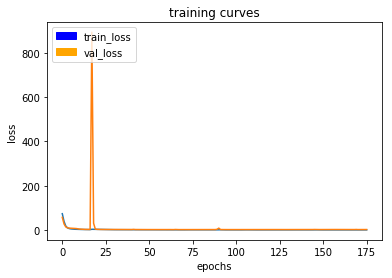

55/55 [==============================] - 60s 1s/step - loss: 0.7323 - val_loss: 2.4763
Epoch 177/200
54/55 [============================>.] - ETA: 1s - loss: 0.7232

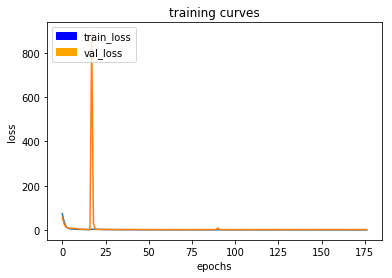

55/55 [==============================] - 60s 1s/step - loss: 0.7250 - val_loss: 2.5184
Epoch 178/200
54/55 [============================>.] - ETA: 1s - loss: 0.7174

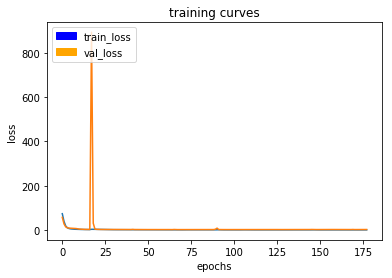

55/55 [==============================] - 61s 1s/step - loss: 0.7178 - val_loss: 2.5632
Epoch 179/200
54/55 [============================>.] - ETA: 1s - loss: 0.7165

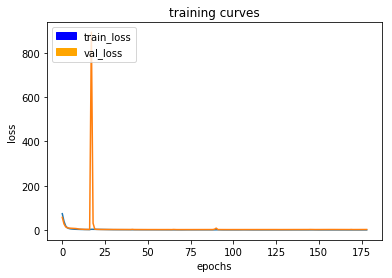

55/55 [==============================] - 60s 1s/step - loss: 0.7143 - val_loss: 2.5893
Epoch 180/200
54/55 [============================>.] - ETA: 1s - loss: 0.7939

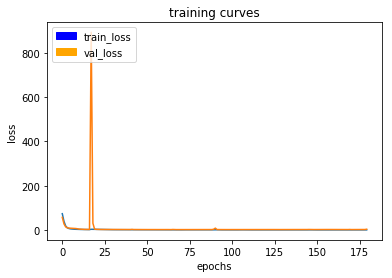

55/55 [==============================] - 60s 1s/step - loss: 0.7954 - val_loss: 3.8488
Epoch 181/200
54/55 [============================>.] - ETA: 1s - loss: 1.0826

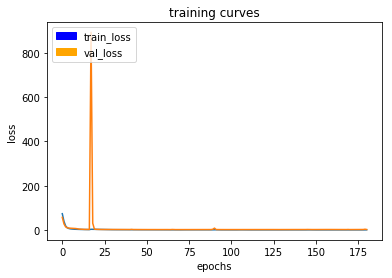

55/55 [==============================] - 60s 1s/step - loss: 1.0791 - val_loss: 2.5402
Epoch 182/200
54/55 [============================>.] - ETA: 1s - loss: 0.8261

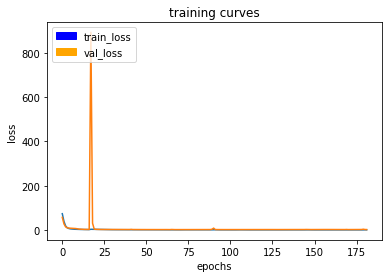

55/55 [==============================] - 60s 1s/step - loss: 0.8237 - val_loss: 2.3305
Epoch 183/200
54/55 [============================>.] - ETA: 1s - loss: 0.8256

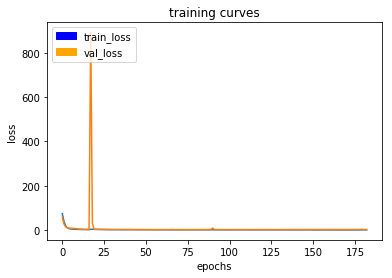

55/55 [==============================] - 60s 1s/step - loss: 0.8268 - val_loss: 2.5080
Epoch 184/200
54/55 [============================>.] - ETA: 0s - loss: 0.8455

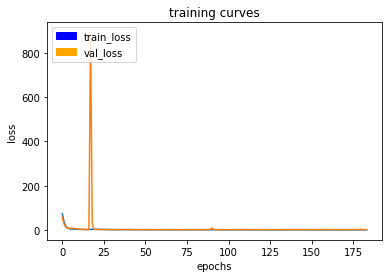

55/55 [==============================] - 60s 1s/step - loss: 0.8438 - val_loss: 2.4487
Epoch 185/200
54/55 [============================>.] - ETA: 1s - loss: 0.7885

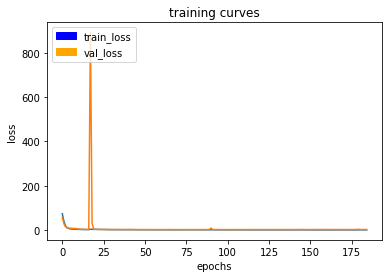

55/55 [==============================] - 60s 1s/step - loss: 0.7874 - val_loss: 2.4843
Epoch 186/200
54/55 [============================>.] - ETA: 1s - loss: 0.7485

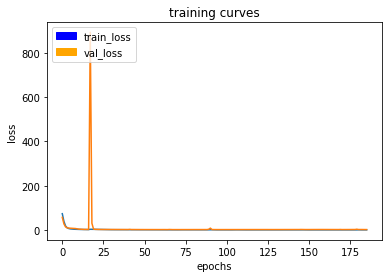

55/55 [==============================] - 61s 1s/step - loss: 0.7488 - val_loss: 2.2593
Epoch 187/200
54/55 [============================>.] - ETA: 1s - loss: 0.7444

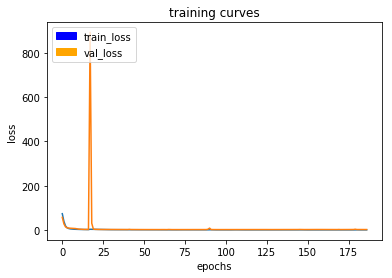

55/55 [==============================] - 61s 1s/step - loss: 0.7444 - val_loss: 2.4326
Epoch 188/200
54/55 [============================>.] - ETA: 1s - loss: 0.7230

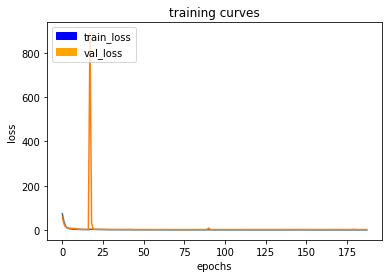

55/55 [==============================] - 60s 1s/step - loss: 0.7241 - val_loss: 2.4408
Epoch 189/200
54/55 [============================>.] - ETA: 1s - loss: 0.7159

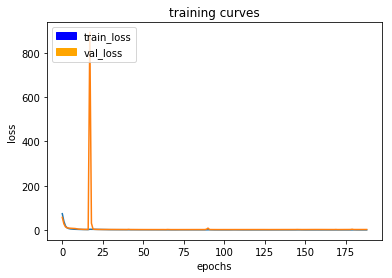

55/55 [==============================] - 61s 1s/step - loss: 0.7171 - val_loss: 2.5456
Epoch 190/200
54/55 [============================>.] - ETA: 1s - loss: 0.7127

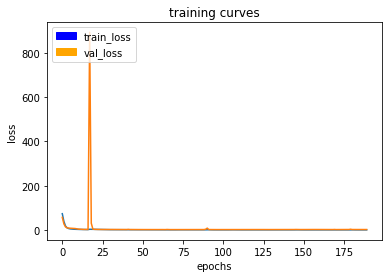

55/55 [==============================] - 60s 1s/step - loss: 0.7117 - val_loss: 2.4698
Epoch 191/200
54/55 [============================>.] - ETA: 1s - loss: 0.7120

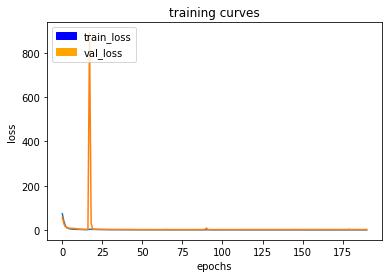

55/55 [==============================] - 60s 1s/step - loss: 0.7136 - val_loss: 2.5818
Epoch 192/200
54/55 [============================>.] - ETA: 1s - loss: 0.7122

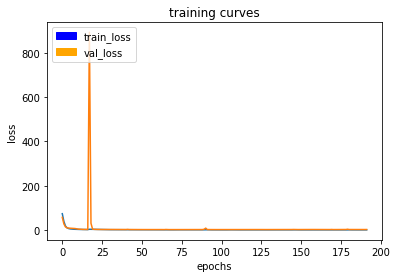

55/55 [==============================] - 60s 1s/step - loss: 0.7114 - val_loss: 2.5370
Epoch 193/200
54/55 [============================>.] - ETA: 1s - loss: 0.6963

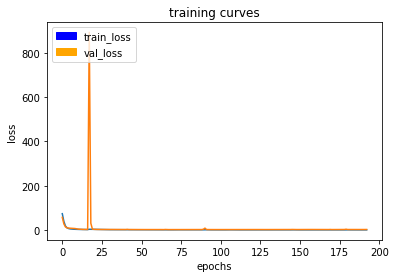

55/55 [==============================] - 60s 1s/step - loss: 0.6963 - val_loss: 2.5996
Epoch 194/200
54/55 [============================>.] - ETA: 1s - loss: 0.6942

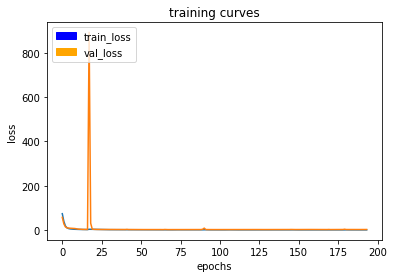

55/55 [==============================] - 60s 1s/step - loss: 0.6950 - val_loss: 2.6023
Epoch 195/200
54/55 [============================>.] - ETA: 1s - loss: 0.6902

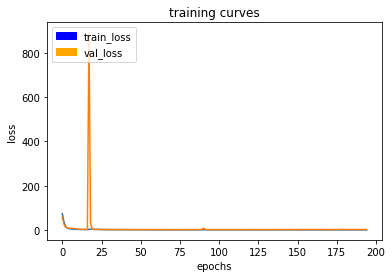

55/55 [==============================] - 60s 1s/step - loss: 0.6908 - val_loss: 2.6126
Epoch 196/200
54/55 [============================>.] - ETA: 1s - loss: 0.6935

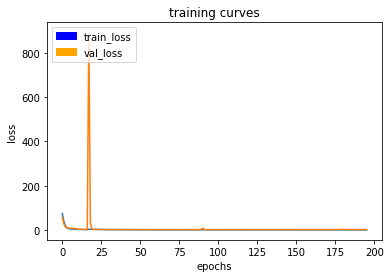

55/55 [==============================] - 61s 1s/step - loss: 0.6931 - val_loss: 2.6419
Epoch 197/200
54/55 [============================>.] - ETA: 1s - loss: 0.6941

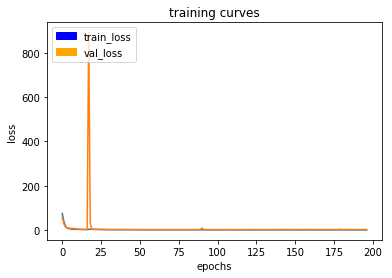

55/55 [==============================] - 61s 1s/step - loss: 0.6934 - val_loss: 2.5906
Epoch 198/200
54/55 [============================>.] - ETA: 1s - loss: 0.6926

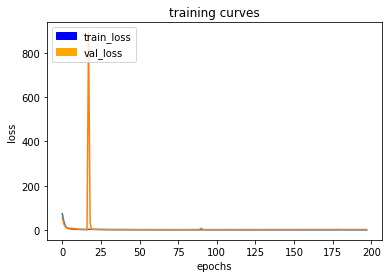

55/55 [==============================] - 61s 1s/step - loss: 0.6920 - val_loss: 2.5735
Epoch 199/200
54/55 [============================>.] - ETA: 1s - loss: 0.7040

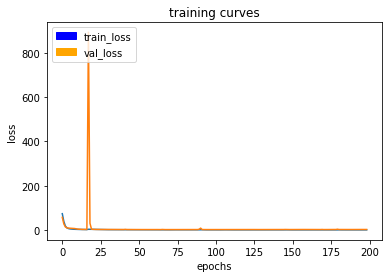

55/55 [==============================] - 60s 1s/step - loss: 0.7056 - val_loss: 2.6455
Epoch 200/200
54/55 [============================>.] - ETA: 1s - loss: 0.7242

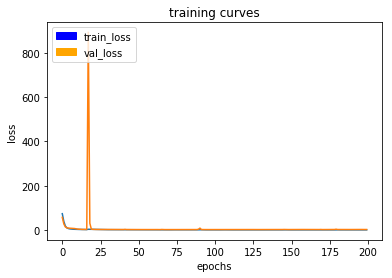

55/55 [==============================] - 61s 1s/step - loss: 0.7229 - val_loss: 2.5143


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [11]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)
print(model)


Consider using a TensorFlow optimizer from `tf.train`.


## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [12]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
weight_file_name = 'model_weights'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = ''

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(
    model, run_num, 'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(
    model, run_num, 'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(
    model, run_num,'following_images', 'sample_evaluation_data')

..\data\sample_evaluation_data\patrol_with_targ
..\data\sample_evaluation_data\patrol_non_targ
..\data\sample_evaluation_data\following_images


Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

..\data\sample_evaluation_data


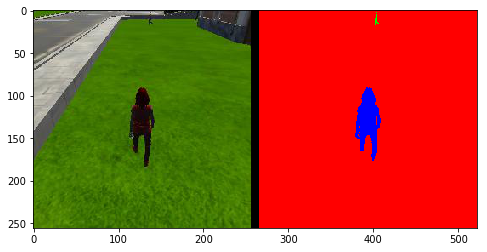

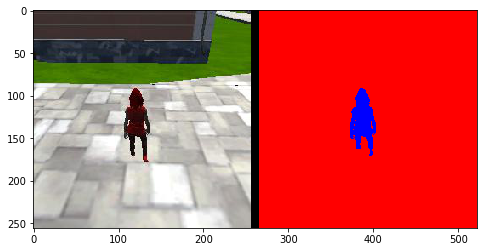

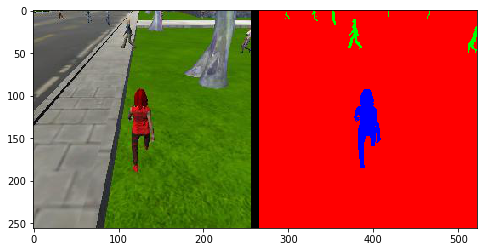

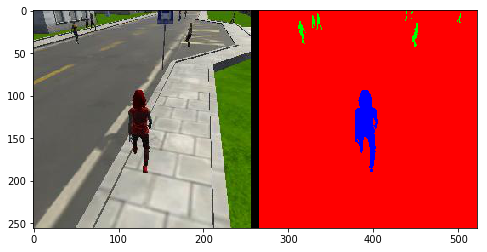

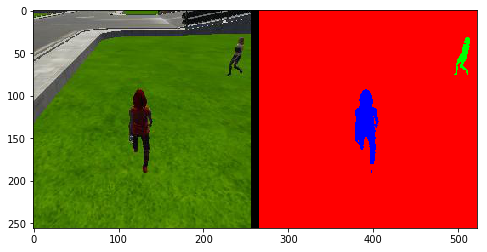

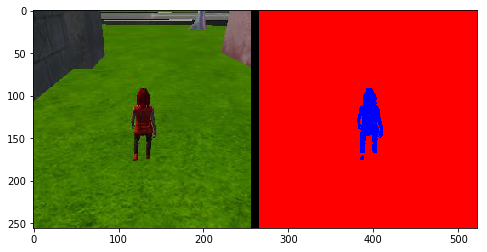

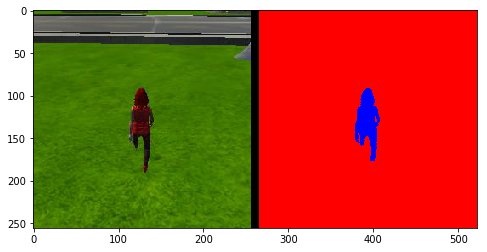

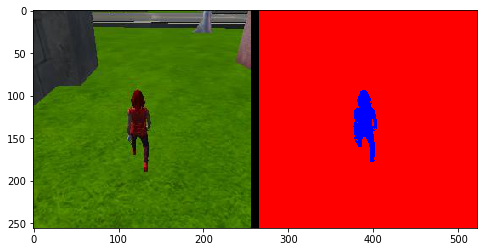

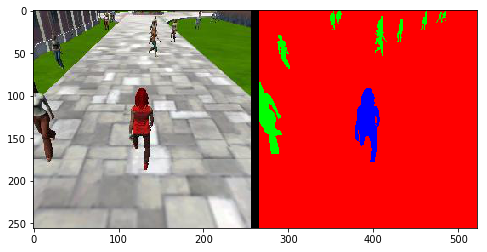

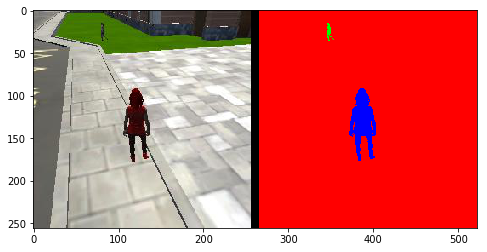

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num)
for file in im_files:
    im_tuple = plotting_tools.load_images(file)
    plotting_tools.show_images(im_tuple)
    

..\data\sample_evaluation_data


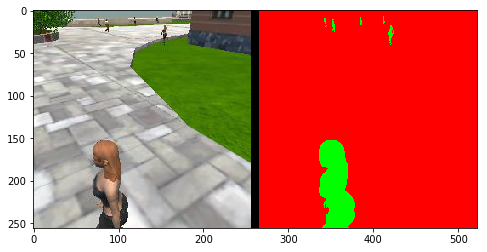

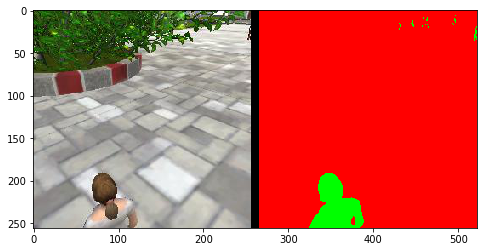

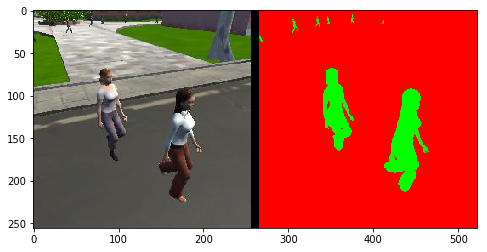

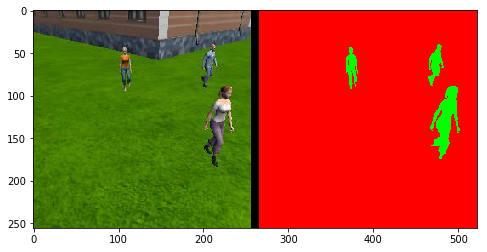

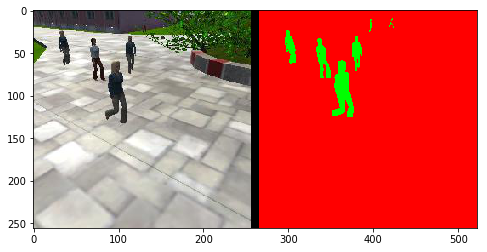

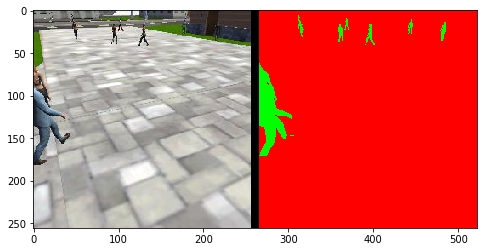

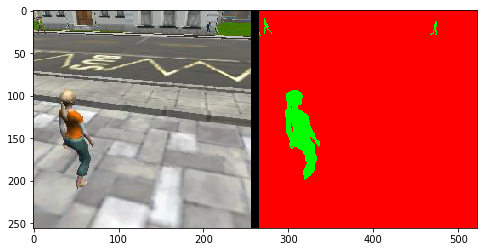

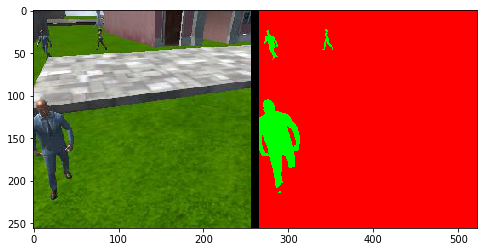

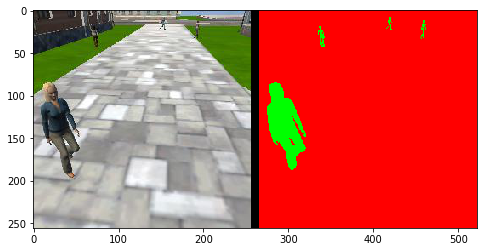

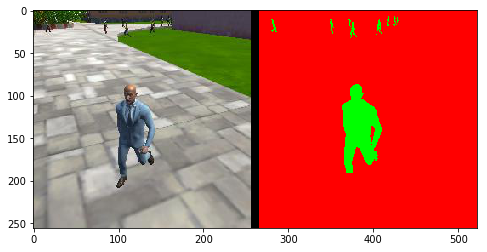

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for file in im_files:
    im_tuple = plotting_tools.load_images(file)
    plotting_tools.show_images(im_tuple)
 

..\data\sample_evaluation_data


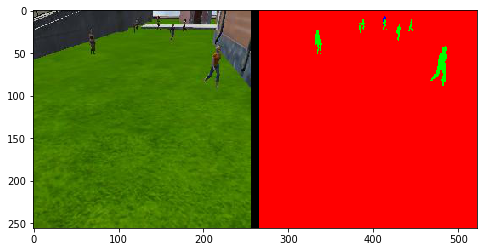

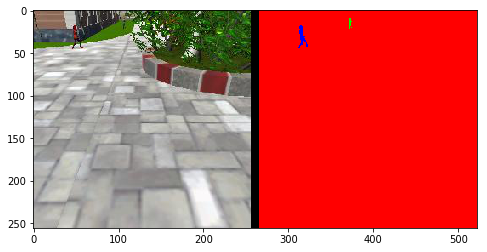

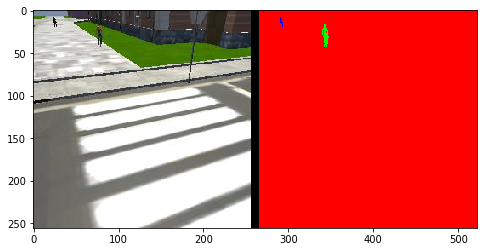

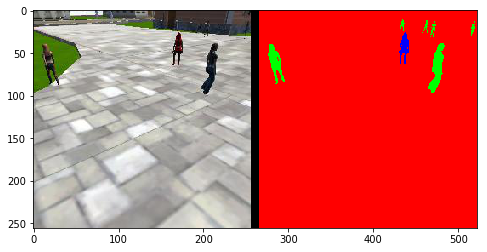

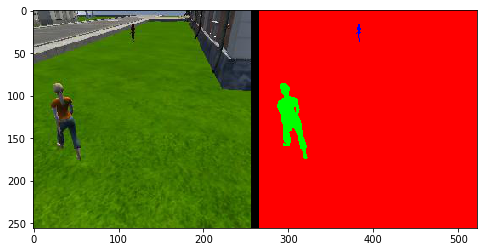

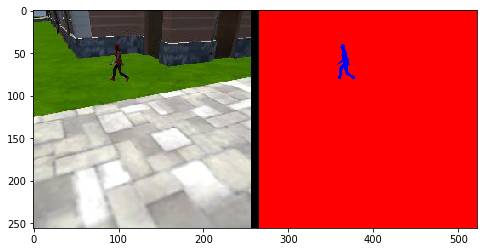

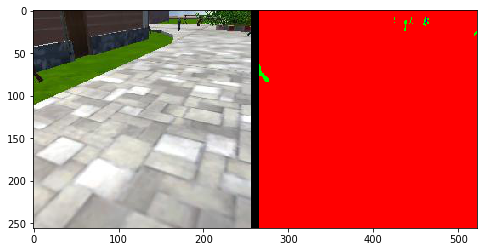

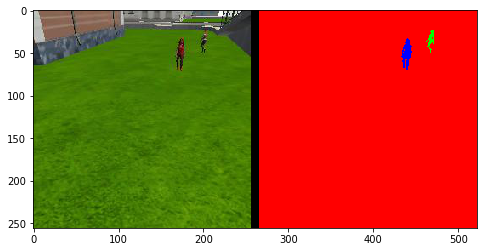

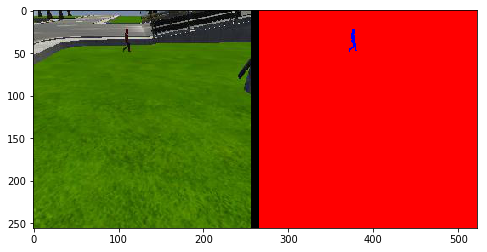

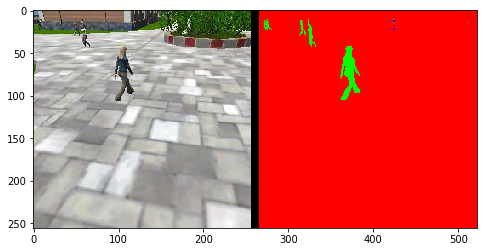

In [16]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for file in im_files:
    im_tuple = plotting_tools.load_images(file)
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954319045168872
average intersection over union for other people is 0.35878834534751525
average intersection over union for the hero is 0.9192028394536664
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9868579009181561
average intersection over union for other people is 0.7372604647651148
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 73, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9961235673115285
average intersection over union for other people is 0.44465877755698535
average intersection over union for the hero is 0.27975218729820905
number true positives: 160, number false positives: 3, number false negatives: 141


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7631004366812227


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5994775133759378


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.4574615522377517
